In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import abstract_gradient_training as agt
import sklearn
import copy
import gurobipy as gp
from gurobipy import GRB
import json
from tqdm import tqdm
import random
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots

In [ ]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
# dev = "cpu"
device = torch.device(dev)
print(f"Using device: {device}")

Using device: cpu


In [9]:
# get data
ensemble_size = 20
"""Initialise the halfmoons training data."""
seed = 0
total_dataset_size = 100000
train_dataset_size_per_member = total_dataset_size//ensemble_size  # number of samples per batch
batch_size = train_dataset_size_per_member // 2
test_size = 1000
# n_batches = 3  # number of batches per epoch
n_epochs = 4  # number of epochs
dpa_prop = 0.0 # proportion of data to use for DPA without AGT

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=ensemble_size*train_dataset_size_per_member + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))
# perform a test-train split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size / (ensemble_size*train_dataset_size_per_member + test_size), random_state=seed
)

# convert into pytorch dataloaders
x_train, y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).to(device)
x_test, y_test = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).to(device)
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=250, shuffle=False)

In [10]:

"""Train an ensemble of classifiers on the AGT dataset."""
NOMINAL_CONFIG = agt.AGTConfig(
    learning_rate=3.0,
    n_epochs=4,
    device=dev,
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    log_level="DEBUG",
    # paired_poison=True,
    clip_gamma=1.0,
)

ensemble = []
num_dpa = int(dpa_prop * ensemble_size)

torch.manual_seed(seed)
indices = torch.randperm(len(dataset_train))
for t in range(ensemble_size):
    trained_models = []
    model_t = torch.nn.Sequential(
        torch.nn.Linear(7, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    ).to(device)
    conf = copy.deepcopy(NOMINAL_CONFIG)
    conf.n_epochs = 7
    if t >= num_dpa:
        # Smaller model for AGT
        print(f"Smaller model for AGT member {t}")
        model_t = torch.nn.Sequential(torch.nn.Linear(7, 2).to(device))
        conf.learning_rate = 2.0
        conf.n_epochs = 4
    bounded_model_t = agt.bounded_models.IntervalBoundedModel(model_t)
    # create a disjoint subset of the training data
    dataset_train_t = torch.utils.data.Subset(dataset_train, indices[t::ensemble_size])  # type: ignore
    dataloader_t = torch.utils.data.DataLoader(dataset_train_t, batch_size=batch_size, shuffle=True)
    ensemble.append((bounded_model_t, dataloader_t, conf))

Smaller model for AGT member 0
Smaller model for AGT member 1
Smaller model for AGT member 2
Smaller model for AGT member 3
Smaller model for AGT member 4
Smaller model for AGT member 5
Smaller model for AGT member 6
Smaller model for AGT member 7
Smaller model for AGT member 8
Smaller model for AGT member 9
Smaller model for AGT member 10
Smaller model for AGT member 11
Smaller model for AGT member 12
Smaller model for AGT member 13
Smaller model for AGT member 14
Smaller model for AGT member 15
Smaller model for AGT member 16
Smaller model for AGT member 17
Smaller model for AGT member 18
Smaller model for AGT member 19


#### TRAINING

In [87]:
gridsize = 100
test_size = gridsize ** 2

# define a grid of points and add features
x0 = torch.linspace(-1.5, 2.5, gridsize)
x1 = torch.linspace(-1.2, 2.2, gridsize)
X0, X1 = torch.meshgrid(x0, x1)
X0f, X1f = X0.flatten(), X1.flatten()
grid_data = torch.stack((X0f, X1f, X0f**2, X1f**2, X0f * X1f, X0f ** 3, X1f ** 3), dim=1)
grid_data = grid_data.to(device)
print(grid_data.shape)

torch.Size([10000, 7])


/vol/bitbucket/spo21/myenv/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [89]:
# compute b up to N=5
n = len(grid_data)
m = len(ensemble)
b = torch.zeros((m, n)).to(device)
N = 8
s = 2


trained_ensemble = []
for (i, (bounded_model_t, dataloader_t, config)) in enumerate(ensemble):        
    trained_models = {}
    # Get the largest value of poisoned points before model prediction is no longer robust
    # Train models with different values of k, always compute for k_poison=N
    k_poisons = list(range(1, N+1, s)) + [N]  # include N as the last value
    if i < num_dpa:
        k_poisons = [1]
    for k_poison in k_poisons: # try by enumerating all values of k_poison
        model_copy = copy.deepcopy(bounded_model_t)
        print(f"Training model {i} with k={k_poison}")
        torch.manual_seed(i)
        conf = copy.deepcopy(config)
        conf.k_private = k_poison
        print(conf.device)
        # conf.epsilon = 0.01
        trained_model = agt.privacy_certified_training(model_copy, conf, dataloader_t, dataloader_test)
        trained_models[k_poison] = copy.deepcopy(trained_model)
    
        if k_poison == 1:
            trained_ensemble.append(copy.deepcopy(trained_model))
        
    if i < num_dpa:
        print(f"Setting b to 1 for model {i} (DPA)")
        b[i] = torch.ones(n).to(device)
        continue
    # tensor of size (1xlen(grid_data))
    bs = agt.privacy_utils.compute_max_certified_k(grid_data, trained_models) + 1
    b[i] = bs.clone()
    # print(bs)
torch.save(b, f".prop_results/moons_agt_bs_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")


[AGT] [INFO    ] [21:46:23] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [21:46:23] 	Optimizer params: n_epochs=4, learning_rate=2.0, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [21:46:23] 	Learning rate schedule: lr_decay=0.6, lr_min=0.001
[AGT] [DEBUG   ] [21:46:23] 	Gradient clipping: gamma=1.0, method=clamp
[AGT] [DEBUG   ] [21:46:23] 	Privacy parameter: k_private=1
[AGT] [INFO    ] [21:46:23] Starting epoch 1 of 4.
[AGT] [DEBUG   ] [21:46:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:23] Batch 1. Loss (accuracy) 0.540 <= 0.540 <= 0.540


Training model 0 with k=1
cpu


[AGT] [INFO    ] [21:46:23] Batch 2. Loss (accuracy) 0.860 <= 0.860 <= 0.860
[AGT] [INFO    ] [21:46:23] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:23] Batch 1. Loss (accuracy) 0.828 <= 0.828 <= 0.836
[AGT] [INFO    ] [21:46:24] Batch 2. Loss (accuracy) 0.884 <= 0.884 <= 0.892
[AGT] [INFO    ] [21:46:24] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:24] Batch 1. Loss (accuracy) 0.884 <= 0.888 <= 0.896
[AGT] [INFO    ] [21:46:24] Batch 2. Loss (accuracy) 0.876 <= 0.892 <= 0.896
[AGT] [INFO    ] [21:46:24] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:24] Batch 1. Loss (accuracy) 0.852 <= 0.872 <= 0.872
[AGT] [INFO    ] [21:46:25] Batch 2. Loss (accuracy) 0.904 <= 0.908 <= 0.916
[AGT] [INFO    ] [21:46:25] Final Eval. Loss (accuracy): 0.896 <= 0.904 <= 0.912
[AGT] [INFO    ] 

Training model 0 with k=3
cpu


[AGT] [INFO    ] [21:46:25] Batch 2. Loss (accuracy) 0.856 <= 0.860 <= 0.860
[AGT] [INFO    ] [21:46:25] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:25] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.836
[AGT] [INFO    ] [21:46:26] Batch 2. Loss (accuracy) 0.880 <= 0.884 <= 0.900
[AGT] [INFO    ] [21:46:26] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:26] Batch 1. Loss (accuracy) 0.876 <= 0.888 <= 0.912
[AGT] [INFO    ] [21:46:26] Batch 2. Loss (accuracy) 0.852 <= 0.892 <= 0.912
[AGT] [INFO    ] [21:46:26] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:27] Batch 1. Loss (accuracy) 0.828 <= 0.872 <= 0.888
[AGT] [INFO    ] [21:46:27] Batch 2. Loss (accuracy) 0.876 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:46:27] Final Eval. Loss (accuracy): 0.868 <= 0.904 <= 0.940
[AGT] [INFO    ] 

Training model 0 with k=5
cpu


[AGT] [INFO    ] [21:46:27] Batch 2. Loss (accuracy) 0.856 <= 0.860 <= 0.860
[AGT] [INFO    ] [21:46:28] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:28] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.836
[AGT] [INFO    ] [21:46:28] Batch 2. Loss (accuracy) 0.868 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:46:28] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:28] Batch 1. Loss (accuracy) 0.864 <= 0.888 <= 0.924
[AGT] [INFO    ] [21:46:29] Batch 2. Loss (accuracy) 0.836 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:46:29] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:29] Batch 1. Loss (accuracy) 0.800 <= 0.872 <= 0.900
[AGT] [INFO    ] [21:46:29] Batch 2. Loss (accuracy) 0.844 <= 0.908 <= 0.940
[AGT] [INFO    ] [21:46:30] Final Eval. Loss (accuracy): 0.844 <= 0.904 <= 0.960
[AGT] [INFO    ] 

Training model 0 with k=7
cpu


[AGT] [INFO    ] [21:46:30] Batch 2. Loss (accuracy) 0.848 <= 0.860 <= 0.860
[AGT] [INFO    ] [21:46:30] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:30] Batch 1. Loss (accuracy) 0.812 <= 0.828 <= 0.848
[AGT] [INFO    ] [21:46:31] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.912
[AGT] [INFO    ] [21:46:31] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:31] Batch 1. Loss (accuracy) 0.860 <= 0.888 <= 0.924
[AGT] [INFO    ] [21:46:31] Batch 2. Loss (accuracy) 0.820 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:46:31] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:31] Batch 1. Loss (accuracy) 0.780 <= 0.872 <= 0.928
[AGT] [INFO    ] [21:46:32] Batch 2. Loss (accuracy) 0.808 <= 0.908 <= 0.952
[AGT] [INFO    ] [21:46:32] Final Eval. Loss (accuracy): 0.812 <= 0.904 <= 0.972
[AGT] [INFO    ] 

Training model 0 with k=8
cpu


[AGT] [INFO    ] [21:46:32] Batch 2. Loss (accuracy) 0.848 <= 0.860 <= 0.860
[AGT] [INFO    ] [21:46:32] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:33] Batch 1. Loss (accuracy) 0.808 <= 0.828 <= 0.852
[AGT] [INFO    ] [21:46:33] Batch 2. Loss (accuracy) 0.848 <= 0.884 <= 0.912
[AGT] [INFO    ] [21:46:33] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:33] Batch 1. Loss (accuracy) 0.852 <= 0.888 <= 0.928
[AGT] [INFO    ] [21:46:33] Batch 2. Loss (accuracy) 0.812 <= 0.892 <= 0.940
[AGT] [INFO    ] [21:46:34] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:34] Batch 1. Loss (accuracy) 0.772 <= 0.872 <= 0.936
[AGT] [INFO    ] [21:46:34] Batch 2. Loss (accuracy) 0.796 <= 0.908 <= 0.956
[AGT] [INFO    ] [21:46:34] Final Eval. Loss (accuracy): 0.740 <= 0.904 <= 0.984
[AGT] [INFO    ] 

Training model 1 with k=1
cpu


[AGT] [INFO    ] [21:46:34] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:46:35] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:35] Batch 1. Loss (accuracy) 0.820 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:46:35] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.880
[AGT] [INFO    ] [21:46:35] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:35] Batch 1. Loss (accuracy) 0.876 <= 0.888 <= 0.888
[AGT] [INFO    ] [21:46:35] Batch 2. Loss (accuracy) 0.864 <= 0.864 <= 0.868
[AGT] [INFO    ] [21:46:36] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:36] Batch 1. Loss (accuracy) 0.836 <= 0.844 <= 0.848
[AGT] [INFO    ] [21:46:36] Batch 2. Loss (accuracy) 0.892 <= 0.896 <= 0.912
[AGT] [INFO    ] [21:46:36] Final Eval. Loss (accuracy): 0.888 <= 0.900 <= 0.904
[AGT] [INFO    ] 

Training model 1 with k=3
cpu


[AGT] [INFO    ] [21:46:37] Batch 2. Loss (accuracy) 0.824 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:46:37] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:37] Batch 1. Loss (accuracy) 0.816 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:46:37] Batch 2. Loss (accuracy) 0.876 <= 0.880 <= 0.884
[AGT] [INFO    ] [21:46:37] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:37] Batch 1. Loss (accuracy) 0.872 <= 0.888 <= 0.900
[AGT] [INFO    ] [21:46:38] Batch 2. Loss (accuracy) 0.840 <= 0.864 <= 0.876
[AGT] [INFO    ] [21:46:38] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:38] Batch 1. Loss (accuracy) 0.832 <= 0.844 <= 0.864
[AGT] [INFO    ] [21:46:38] Batch 2. Loss (accuracy) 0.876 <= 0.896 <= 0.924
[AGT] [INFO    ] [21:46:38] Final Eval. Loss (accuracy): 0.872 <= 0.900 <= 0.920
[AGT] [INFO    ] 

Training model 1 with k=5
cpu


[AGT] [INFO    ] [21:46:39] Batch 2. Loss (accuracy) 0.824 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:46:39] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:39] Batch 1. Loss (accuracy) 0.808 <= 0.824 <= 0.832
[AGT] [INFO    ] [21:46:39] Batch 2. Loss (accuracy) 0.864 <= 0.880 <= 0.892
[AGT] [INFO    ] [21:46:40] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:40] Batch 1. Loss (accuracy) 0.868 <= 0.888 <= 0.900
[AGT] [INFO    ] [21:46:40] Batch 2. Loss (accuracy) 0.828 <= 0.864 <= 0.896
[AGT] [INFO    ] [21:46:40] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:40] Batch 1. Loss (accuracy) 0.812 <= 0.844 <= 0.892
[AGT] [INFO    ] [21:46:40] Batch 2. Loss (accuracy) 0.860 <= 0.896 <= 0.936
[AGT] [INFO    ] [21:46:41] Final Eval. Loss (accuracy): 0.856 <= 0.900 <= 0.948
[AGT] [INFO    ] 

Training model 1 with k=7
cpu


[AGT] [INFO    ] [21:46:41] Batch 2. Loss (accuracy) 0.812 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:46:41] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:41] Batch 1. Loss (accuracy) 0.808 <= 0.824 <= 0.832
[AGT] [INFO    ] [21:46:41] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.896
[AGT] [INFO    ] [21:46:42] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:42] Batch 1. Loss (accuracy) 0.864 <= 0.888 <= 0.904
[AGT] [INFO    ] [21:46:42] Batch 2. Loss (accuracy) 0.820 <= 0.864 <= 0.920
[AGT] [INFO    ] [21:46:42] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:42] Batch 1. Loss (accuracy) 0.800 <= 0.844 <= 0.916
[AGT] [INFO    ] [21:46:43] Batch 2. Loss (accuracy) 0.832 <= 0.896 <= 0.952
[AGT] [INFO    ] [21:46:43] Final Eval. Loss (accuracy): 0.840 <= 0.900 <= 0.964
[AGT] [INFO    ] 

Training model 1 with k=8
cpu


[AGT] [INFO    ] [21:46:43] Batch 2. Loss (accuracy) 0.812 <= 0.832 <= 0.836
[AGT] [INFO    ] [21:46:43] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:43] Batch 1. Loss (accuracy) 0.804 <= 0.824 <= 0.836
[AGT] [INFO    ] [21:46:44] Batch 2. Loss (accuracy) 0.856 <= 0.880 <= 0.900
[AGT] [INFO    ] [21:46:44] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:44] Batch 1. Loss (accuracy) 0.860 <= 0.888 <= 0.908
[AGT] [INFO    ] [21:46:44] Batch 2. Loss (accuracy) 0.812 <= 0.864 <= 0.924
[AGT] [INFO    ] [21:46:45] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:45] Batch 1. Loss (accuracy) 0.788 <= 0.844 <= 0.932
[AGT] [INFO    ] [21:46:45] Batch 2. Loss (accuracy) 0.820 <= 0.896 <= 0.952
[AGT] [INFO    ] [21:46:45] Final Eval. Loss (accuracy): 0.832 <= 0.900 <= 0.972
[AGT] [INFO    ] 

Training model 2 with k=1
cpu


[AGT] [INFO    ] [21:46:46] Batch 2. Loss (accuracy) 0.864 <= 0.868 <= 0.868
[AGT] [INFO    ] [21:46:46] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:46] Batch 1. Loss (accuracy) 0.848 <= 0.848 <= 0.848
[AGT] [INFO    ] [21:46:46] Batch 2. Loss (accuracy) 0.912 <= 0.916 <= 0.920
[AGT] [INFO    ] [21:46:47] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:47] Batch 1. Loss (accuracy) 0.908 <= 0.908 <= 0.916
[AGT] [INFO    ] [21:46:47] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:46:47] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:47] Batch 1. Loss (accuracy) 0.876 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:46:48] Batch 2. Loss (accuracy) 0.908 <= 0.932 <= 0.940
[AGT] [INFO    ] [21:46:48] Final Eval. Loss (accuracy): 0.904 <= 0.928 <= 0.944
[AGT] [INFO    ] 

Training model 2 with k=3
cpu


[AGT] [INFO    ] [21:46:48] Batch 2. Loss (accuracy) 0.864 <= 0.868 <= 0.868
[AGT] [INFO    ] [21:46:48] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:48] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.852
[AGT] [INFO    ] [21:46:49] Batch 2. Loss (accuracy) 0.904 <= 0.916 <= 0.924
[AGT] [INFO    ] [21:46:49] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:49] Batch 1. Loss (accuracy) 0.892 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:46:49] Batch 2. Loss (accuracy) 0.868 <= 0.900 <= 0.940
[AGT] [INFO    ] [21:46:49] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:49] Batch 1. Loss (accuracy) 0.836 <= 0.900 <= 0.948
[AGT] [INFO    ] [21:46:50] Batch 2. Loss (accuracy) 0.884 <= 0.932 <= 0.972
[AGT] [INFO    ] [21:46:50] Final Eval. Loss (accuracy): 0.876 <= 0.928 <= 0.984
[AGT] [INFO    ] 

Training model 2 with k=5
cpu


[AGT] [INFO    ] [21:46:50] Batch 2. Loss (accuracy) 0.864 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:46:50] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:50] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.868
[AGT] [INFO    ] [21:46:51] Batch 2. Loss (accuracy) 0.888 <= 0.916 <= 0.936
[AGT] [INFO    ] [21:46:51] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:51] Batch 1. Loss (accuracy) 0.880 <= 0.908 <= 0.952
[AGT] [INFO    ] [21:46:51] Batch 2. Loss (accuracy) 0.852 <= 0.900 <= 0.952
[AGT] [INFO    ] [21:46:51] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:51] Batch 1. Loss (accuracy) 0.820 <= 0.900 <= 0.968
[AGT] [INFO    ] [21:46:52] Batch 2. Loss (accuracy) 0.852 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:46:52] Final Eval. Loss (accuracy): 0.844 <= 0.928 <= 0.992
[AGT] [INFO    ] 

Training model 2 with k=7
cpu


[AGT] [INFO    ] [21:46:52] Batch 2. Loss (accuracy) 0.852 <= 0.868 <= 0.876
[AGT] [INFO    ] [21:46:53] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:53] Batch 1. Loss (accuracy) 0.836 <= 0.848 <= 0.880
[AGT] [INFO    ] [21:46:53] Batch 2. Loss (accuracy) 0.888 <= 0.916 <= 0.944
[AGT] [INFO    ] [21:46:53] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:53] Batch 1. Loss (accuracy) 0.872 <= 0.908 <= 0.964
[AGT] [INFO    ] [21:46:53] Batch 2. Loss (accuracy) 0.828 <= 0.900 <= 0.960
[AGT] [INFO    ] [21:46:54] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:54] Batch 1. Loss (accuracy) 0.812 <= 0.900 <= 0.972
[AGT] [INFO    ] [21:46:54] Batch 2. Loss (accuracy) 0.752 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:46:54] Final Eval. Loss (accuracy): 0.584 <= 0.928 <= 1.000
[AGT] [INFO    ] 

Training model 2 with k=8
cpu


[AGT] [INFO    ] [21:46:55] Batch 2. Loss (accuracy) 0.852 <= 0.868 <= 0.876
[AGT] [INFO    ] [21:46:55] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:55] Batch 1. Loss (accuracy) 0.836 <= 0.848 <= 0.888
[AGT] [INFO    ] [21:46:55] Batch 2. Loss (accuracy) 0.880 <= 0.916 <= 0.948
[AGT] [INFO    ] [21:46:55] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:55] Batch 1. Loss (accuracy) 0.872 <= 0.908 <= 0.964
[AGT] [INFO    ] [21:46:56] Batch 2. Loss (accuracy) 0.808 <= 0.900 <= 0.964
[AGT] [INFO    ] [21:46:56] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:56] Batch 1. Loss (accuracy) 0.776 <= 0.900 <= 0.976
[AGT] [INFO    ] [21:46:56] Batch 2. Loss (accuracy) 0.700 <= 0.932 <= 0.988
[AGT] [INFO    ] [21:46:56] Final Eval. Loss (accuracy): 0.336 <= 0.928 <= 1.000
[AGT] [INFO    ] 

Training model 3 with k=1
cpu


[AGT] [INFO    ] [21:46:57] Batch 2. Loss (accuracy) 0.852 <= 0.852 <= 0.852
[AGT] [INFO    ] [21:46:57] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:57] Batch 1. Loss (accuracy) 0.880 <= 0.880 <= 0.880
[AGT] [INFO    ] [21:46:57] Batch 2. Loss (accuracy) 0.892 <= 0.900 <= 0.900
[AGT] [INFO    ] [21:46:57] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:57] Batch 1. Loss (accuracy) 0.904 <= 0.908 <= 0.908
[AGT] [INFO    ] [21:46:58] Batch 2. Loss (accuracy) 0.884 <= 0.884 <= 0.892
[AGT] [INFO    ] [21:46:58] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:46:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:58] Batch 1. Loss (accuracy) 0.892 <= 0.896 <= 0.904
[AGT] [INFO    ] [21:46:58] Batch 2. Loss (accuracy) 0.912 <= 0.912 <= 0.932
[AGT] [INFO    ] [21:46:58] Final Eval. Loss (accuracy): 0.904 <= 0.924 <= 0.928
[AGT] [INFO    ] 

Training model 3 with k=3
cpu


[AGT] [INFO    ] [21:46:59] Batch 2. Loss (accuracy) 0.848 <= 0.852 <= 0.852
[AGT] [INFO    ] [21:46:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:46:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:59] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.884
[AGT] [INFO    ] [21:46:59] Batch 2. Loss (accuracy) 0.892 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:46:59] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:46:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:46:59] Batch 1. Loss (accuracy) 0.896 <= 0.908 <= 0.912
[AGT] [INFO    ] [21:47:00] Batch 2. Loss (accuracy) 0.872 <= 0.884 <= 0.896
[AGT] [INFO    ] [21:47:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:00] Batch 1. Loss (accuracy) 0.860 <= 0.896 <= 0.916
[AGT] [INFO    ] [21:47:00] Batch 2. Loss (accuracy) 0.884 <= 0.912 <= 0.956
[AGT] [INFO    ] [21:47:00] Final Eval. Loss (accuracy): 0.884 <= 0.924 <= 0.956
[AGT] [INFO    ] 

Training model 3 with k=5
cpu


[AGT] [INFO    ] [21:47:01] Batch 2. Loss (accuracy) 0.848 <= 0.852 <= 0.852
[AGT] [INFO    ] [21:47:01] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:01] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.888
[AGT] [INFO    ] [21:47:01] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.928
[AGT] [INFO    ] [21:47:01] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:02] Batch 1. Loss (accuracy) 0.892 <= 0.908 <= 0.932
[AGT] [INFO    ] [21:47:02] Batch 2. Loss (accuracy) 0.856 <= 0.884 <= 0.916
[AGT] [INFO    ] [21:47:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:02] Batch 1. Loss (accuracy) 0.832 <= 0.896 <= 0.932
[AGT] [INFO    ] [21:47:02] Batch 2. Loss (accuracy) 0.868 <= 0.912 <= 0.980
[AGT] [INFO    ] [21:47:03] Final Eval. Loss (accuracy): 0.872 <= 0.924 <= 0.976
[AGT] [INFO    ] 

Training model 3 with k=7
cpu


[AGT] [INFO    ] [21:47:03] Batch 2. Loss (accuracy) 0.844 <= 0.852 <= 0.856
[AGT] [INFO    ] [21:47:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:03] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.888
[AGT] [INFO    ] [21:47:03] Batch 2. Loss (accuracy) 0.876 <= 0.900 <= 0.932
[AGT] [INFO    ] [21:47:04] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:04] Batch 1. Loss (accuracy) 0.884 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:47:04] Batch 2. Loss (accuracy) 0.832 <= 0.884 <= 0.928
[AGT] [INFO    ] [21:47:04] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:04] Batch 1. Loss (accuracy) 0.816 <= 0.896 <= 0.944
[AGT] [INFO    ] [21:47:05] Batch 2. Loss (accuracy) 0.836 <= 0.912 <= 0.984
[AGT] [INFO    ] [21:47:05] Final Eval. Loss (accuracy): 0.840 <= 0.924 <= 0.992
[AGT] [INFO    ] 

Training model 3 with k=8
cpu


[AGT] [INFO    ] [21:47:05] Batch 2. Loss (accuracy) 0.844 <= 0.852 <= 0.856
[AGT] [INFO    ] [21:47:05] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:06] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.888
[AGT] [INFO    ] [21:47:06] Batch 2. Loss (accuracy) 0.876 <= 0.900 <= 0.936
[AGT] [INFO    ] [21:47:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:06] Batch 1. Loss (accuracy) 0.884 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:47:06] Batch 2. Loss (accuracy) 0.828 <= 0.884 <= 0.940
[AGT] [INFO    ] [21:47:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:07] Batch 1. Loss (accuracy) 0.816 <= 0.896 <= 0.956
[AGT] [INFO    ] [21:47:07] Batch 2. Loss (accuracy) 0.816 <= 0.912 <= 0.984
[AGT] [INFO    ] [21:47:07] Final Eval. Loss (accuracy): 0.816 <= 0.924 <= 0.992
[AGT] [INFO    ] 

Training model 4 with k=1
cpu


[AGT] [INFO    ] [21:47:08] Batch 2. Loss (accuracy) 0.812 <= 0.812 <= 0.812
[AGT] [INFO    ] [21:47:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:08] Batch 1. Loss (accuracy) 0.816 <= 0.816 <= 0.820
[AGT] [INFO    ] [21:47:08] Batch 2. Loss (accuracy) 0.880 <= 0.888 <= 0.888
[AGT] [INFO    ] [21:47:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:08] Batch 1. Loss (accuracy) 0.888 <= 0.896 <= 0.896
[AGT] [INFO    ] [21:47:09] Batch 2. Loss (accuracy) 0.856 <= 0.872 <= 0.880
[AGT] [INFO    ] [21:47:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:09] Batch 1. Loss (accuracy) 0.848 <= 0.852 <= 0.860
[AGT] [INFO    ] [21:47:09] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.916
[AGT] [INFO    ] [21:47:09] Final Eval. Loss (accuracy): 0.892 <= 0.908 <= 0.908
[AGT] [INFO    ] 

Training model 4 with k=3
cpu


[AGT] [INFO    ] [21:47:10] Batch 2. Loss (accuracy) 0.808 <= 0.812 <= 0.812
[AGT] [INFO    ] [21:47:10] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:10] Batch 1. Loss (accuracy) 0.816 <= 0.816 <= 0.828
[AGT] [INFO    ] [21:47:10] Batch 2. Loss (accuracy) 0.864 <= 0.888 <= 0.900
[AGT] [INFO    ] [21:47:10] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:11] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.900
[AGT] [INFO    ] [21:47:11] Batch 2. Loss (accuracy) 0.848 <= 0.872 <= 0.900
[AGT] [INFO    ] [21:47:11] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:11] Batch 1. Loss (accuracy) 0.832 <= 0.852 <= 0.872
[AGT] [INFO    ] [21:47:11] Batch 2. Loss (accuracy) 0.872 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:47:12] Final Eval. Loss (accuracy): 0.876 <= 0.908 <= 0.936
[AGT] [INFO    ] 

Training model 4 with k=5
cpu


[AGT] [INFO    ] [21:47:12] Batch 2. Loss (accuracy) 0.800 <= 0.812 <= 0.820
[AGT] [INFO    ] [21:47:12] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:12] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:12] Batch 1. Loss (accuracy) 0.808 <= 0.816 <= 0.828
[AGT] [INFO    ] [21:47:12] Batch 2. Loss (accuracy) 0.860 <= 0.888 <= 0.900
[AGT] [INFO    ] [21:47:13] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:13] Batch 1. Loss (accuracy) 0.860 <= 0.896 <= 0.904
[AGT] [INFO    ] [21:47:13] Batch 2. Loss (accuracy) 0.832 <= 0.872 <= 0.912
[AGT] [INFO    ] [21:47:13] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:13] Batch 1. Loss (accuracy) 0.812 <= 0.852 <= 0.900
[AGT] [INFO    ] [21:47:13] Batch 2. Loss (accuracy) 0.856 <= 0.908 <= 0.948
[AGT] [INFO    ] [21:47:14] Final Eval. Loss (accuracy): 0.848 <= 0.908 <= 0.960
[AGT] [INFO    ] 

Training model 4 with k=7
cpu


[AGT] [INFO    ] [21:47:14] Batch 2. Loss (accuracy) 0.796 <= 0.812 <= 0.820
[AGT] [INFO    ] [21:47:14] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:14] Batch 1. Loss (accuracy) 0.796 <= 0.816 <= 0.832
[AGT] [INFO    ] [21:47:15] Batch 2. Loss (accuracy) 0.856 <= 0.888 <= 0.904
[AGT] [INFO    ] [21:47:15] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:15] Batch 1. Loss (accuracy) 0.844 <= 0.896 <= 0.912
[AGT] [INFO    ] [21:47:15] Batch 2. Loss (accuracy) 0.820 <= 0.872 <= 0.924
[AGT] [INFO    ] [21:47:15] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:15] Batch 1. Loss (accuracy) 0.788 <= 0.852 <= 0.940
[AGT] [INFO    ] [21:47:16] Batch 2. Loss (accuracy) 0.816 <= 0.908 <= 0.952
[AGT] [INFO    ] [21:47:16] Final Eval. Loss (accuracy): 0.824 <= 0.908 <= 0.976
[AGT] [INFO    ] 

Training model 4 with k=8
cpu


[AGT] [INFO    ] [21:47:16] Batch 2. Loss (accuracy) 0.796 <= 0.812 <= 0.828
[AGT] [INFO    ] [21:47:16] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:16] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:16] Batch 1. Loss (accuracy) 0.792 <= 0.816 <= 0.832
[AGT] [INFO    ] [21:47:17] Batch 2. Loss (accuracy) 0.856 <= 0.888 <= 0.904
[AGT] [INFO    ] [21:47:17] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:17] Batch 1. Loss (accuracy) 0.840 <= 0.896 <= 0.912
[AGT] [INFO    ] [21:47:17] Batch 2. Loss (accuracy) 0.816 <= 0.872 <= 0.936
[AGT] [INFO    ] [21:47:17] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:18] Batch 1. Loss (accuracy) 0.776 <= 0.852 <= 0.956
[AGT] [INFO    ] [21:47:18] Batch 2. Loss (accuracy) 0.804 <= 0.908 <= 0.960
[AGT] [INFO    ] [21:47:18] Final Eval. Loss (accuracy): 0.808 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 5 with k=1
cpu


[AGT] [INFO    ] [21:47:18] Batch 2. Loss (accuracy) 0.820 <= 0.820 <= 0.820
[AGT] [INFO    ] [21:47:19] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:19] Batch 1. Loss (accuracy) 0.872 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:47:19] Batch 2. Loss (accuracy) 0.884 <= 0.884 <= 0.884
[AGT] [INFO    ] [21:47:19] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:19] Batch 1. Loss (accuracy) 0.892 <= 0.892 <= 0.896
[AGT] [INFO    ] [21:47:20] Batch 2. Loss (accuracy) 0.868 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:47:20] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:20] Batch 1. Loss (accuracy) 0.856 <= 0.868 <= 0.884
[AGT] [INFO    ] [21:47:20] Batch 2. Loss (accuracy) 0.896 <= 0.900 <= 0.908
[AGT] [INFO    ] [21:47:20] Final Eval. Loss (accuracy): 0.884 <= 0.896 <= 0.920
[AGT] [INFO    ] 

Training model 5 with k=3
cpu


[AGT] [INFO    ] [21:47:21] Batch 2. Loss (accuracy) 0.820 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:47:21] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:21] Batch 1. Loss (accuracy) 0.868 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:47:21] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.900
[AGT] [INFO    ] [21:47:22] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:22] Batch 1. Loss (accuracy) 0.888 <= 0.892 <= 0.900
[AGT] [INFO    ] [21:47:22] Batch 2. Loss (accuracy) 0.852 <= 0.876 <= 0.888
[AGT] [INFO    ] [21:47:22] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:22] Batch 1. Loss (accuracy) 0.828 <= 0.868 <= 0.912
[AGT] [INFO    ] [21:47:22] Batch 2. Loss (accuracy) 0.868 <= 0.900 <= 0.936
[AGT] [INFO    ] [21:47:23] Final Eval. Loss (accuracy): 0.876 <= 0.896 <= 0.948
[AGT] [INFO    ] 

Training model 5 with k=5
cpu


[AGT] [INFO    ] [21:47:23] Batch 2. Loss (accuracy) 0.812 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:47:23] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:23] Batch 1. Loss (accuracy) 0.860 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:47:23] Batch 2. Loss (accuracy) 0.872 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:47:24] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:24] Batch 1. Loss (accuracy) 0.884 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:47:24] Batch 2. Loss (accuracy) 0.828 <= 0.876 <= 0.916
[AGT] [INFO    ] [21:47:24] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:24] Batch 1. Loss (accuracy) 0.816 <= 0.868 <= 0.928
[AGT] [INFO    ] [21:47:25] Batch 2. Loss (accuracy) 0.808 <= 0.900 <= 0.972
[AGT] [INFO    ] [21:47:25] Final Eval. Loss (accuracy): 0.788 <= 0.896 <= 0.980
[AGT] [INFO    ] 

Training model 5 with k=7
cpu


[AGT] [INFO    ] [21:47:25] Batch 2. Loss (accuracy) 0.812 <= 0.820 <= 0.832
[AGT] [INFO    ] [21:47:25] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:25] Batch 1. Loss (accuracy) 0.860 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:47:26] Batch 2. Loss (accuracy) 0.864 <= 0.884 <= 0.920
[AGT] [INFO    ] [21:47:26] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:26] Batch 1. Loss (accuracy) 0.872 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:47:26] Batch 2. Loss (accuracy) 0.812 <= 0.876 <= 0.928
[AGT] [INFO    ] [21:47:26] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:27] Batch 1. Loss (accuracy) 0.796 <= 0.868 <= 0.948
[AGT] [INFO    ] [21:47:27] Batch 2. Loss (accuracy) 0.740 <= 0.900 <= 0.980
[AGT] [INFO    ] [21:47:27] Final Eval. Loss (accuracy): 0.656 <= 0.896 <= 0.992
[AGT] [INFO    ] 

Training model 5 with k=8
cpu


[AGT] [INFO    ] [21:47:27] Batch 2. Loss (accuracy) 0.812 <= 0.820 <= 0.832
[AGT] [INFO    ] [21:47:28] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:28] Batch 1. Loss (accuracy) 0.852 <= 0.876 <= 0.880
[AGT] [INFO    ] [21:47:28] Batch 2. Loss (accuracy) 0.852 <= 0.884 <= 0.920
[AGT] [INFO    ] [21:47:28] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:28] Batch 1. Loss (accuracy) 0.872 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:47:29] Batch 2. Loss (accuracy) 0.808 <= 0.876 <= 0.944
[AGT] [INFO    ] [21:47:29] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:29] Batch 1. Loss (accuracy) 0.772 <= 0.868 <= 0.952
[AGT] [INFO    ] [21:47:29] Batch 2. Loss (accuracy) 0.716 <= 0.900 <= 0.984
[AGT] [INFO    ] [21:47:29] Final Eval. Loss (accuracy): 0.584 <= 0.896 <= 0.992
[AGT] [INFO    ] 

Training model 6 with k=1
cpu


[AGT] [INFO    ] [21:47:30] Batch 2. Loss (accuracy) 0.832 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:47:30] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:30] Batch 1. Loss (accuracy) 0.824 <= 0.828 <= 0.836
[AGT] [INFO    ] [21:47:30] Batch 2. Loss (accuracy) 0.892 <= 0.892 <= 0.896
[AGT] [INFO    ] [21:47:31] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:31] Batch 1. Loss (accuracy) 0.884 <= 0.892 <= 0.900
[AGT] [INFO    ] [21:47:31] Batch 2. Loss (accuracy) 0.876 <= 0.880 <= 0.892
[AGT] [INFO    ] [21:47:31] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:31] Batch 1. Loss (accuracy) 0.860 <= 0.868 <= 0.884
[AGT] [INFO    ] [21:47:31] Batch 2. Loss (accuracy) 0.908 <= 0.916 <= 0.928
[AGT] [INFO    ] [21:47:32] Final Eval. Loss (accuracy): 0.908 <= 0.908 <= 0.932
[AGT] [INFO    ] 

Training model 6 with k=3
cpu


[AGT] [INFO    ] [21:47:32] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:47:32] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:32] Batch 1. Loss (accuracy) 0.824 <= 0.828 <= 0.848
[AGT] [INFO    ] [21:47:33] Batch 2. Loss (accuracy) 0.884 <= 0.892 <= 0.904
[AGT] [INFO    ] [21:47:33] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:33] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.908
[AGT] [INFO    ] [21:47:33] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.904
[AGT] [INFO    ] [21:47:33] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:33] Batch 1. Loss (accuracy) 0.836 <= 0.868 <= 0.924
[AGT] [INFO    ] [21:47:34] Batch 2. Loss (accuracy) 0.888 <= 0.916 <= 0.944
[AGT] [INFO    ] [21:47:34] Final Eval. Loss (accuracy): 0.880 <= 0.908 <= 0.944
[AGT] [INFO    ] 

Training model 6 with k=5
cpu


[AGT] [INFO    ] [21:47:34] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:47:35] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:35] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.848
[AGT] [INFO    ] [21:47:35] Batch 2. Loss (accuracy) 0.872 <= 0.892 <= 0.908
[AGT] [INFO    ] [21:47:35] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:35] Batch 1. Loss (accuracy) 0.876 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:47:35] Batch 2. Loss (accuracy) 0.848 <= 0.880 <= 0.928
[AGT] [INFO    ] [21:47:36] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:36] Batch 1. Loss (accuracy) 0.824 <= 0.868 <= 0.936
[AGT] [INFO    ] [21:47:36] Batch 2. Loss (accuracy) 0.860 <= 0.916 <= 0.972
[AGT] [INFO    ] [21:47:36] Final Eval. Loss (accuracy): 0.872 <= 0.908 <= 0.980
[AGT] [INFO    ] 

Training model 6 with k=7
cpu


[AGT] [INFO    ] [21:47:36] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:47:37] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:37] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.856
[AGT] [INFO    ] [21:47:37] Batch 2. Loss (accuracy) 0.872 <= 0.892 <= 0.912
[AGT] [INFO    ] [21:47:37] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:37] Batch 1. Loss (accuracy) 0.872 <= 0.892 <= 0.936
[AGT] [INFO    ] [21:47:38] Batch 2. Loss (accuracy) 0.832 <= 0.880 <= 0.940
[AGT] [INFO    ] [21:47:38] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:38] Batch 1. Loss (accuracy) 0.808 <= 0.868 <= 0.952
[AGT] [INFO    ] [21:47:38] Batch 2. Loss (accuracy) 0.836 <= 0.916 <= 0.984
[AGT] [INFO    ] [21:47:38] Final Eval. Loss (accuracy): 0.840 <= 0.908 <= 0.988
[AGT] [INFO    ] 

Training model 6 with k=8
cpu


[AGT] [INFO    ] [21:47:39] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:47:39] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:39] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.860
[AGT] [INFO    ] [21:47:39] Batch 2. Loss (accuracy) 0.864 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:47:39] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:40] Batch 1. Loss (accuracy) 0.872 <= 0.892 <= 0.936
[AGT] [INFO    ] [21:47:40] Batch 2. Loss (accuracy) 0.816 <= 0.880 <= 0.944
[AGT] [INFO    ] [21:47:40] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:40] Batch 1. Loss (accuracy) 0.800 <= 0.868 <= 0.960
[AGT] [INFO    ] [21:47:40] Batch 2. Loss (accuracy) 0.804 <= 0.916 <= 0.984
[AGT] [INFO    ] [21:47:41] Final Eval. Loss (accuracy): 0.804 <= 0.908 <= 0.992
[AGT] [INFO    ] 

Training model 7 with k=1
cpu


[AGT] [INFO    ] [21:47:41] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.868
[AGT] [INFO    ] [21:47:41] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:41] Batch 1. Loss (accuracy) 0.856 <= 0.856 <= 0.860
[AGT] [INFO    ] [21:47:42] Batch 2. Loss (accuracy) 0.916 <= 0.920 <= 0.920
[AGT] [INFO    ] [21:47:42] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:42] Batch 1. Loss (accuracy) 0.908 <= 0.916 <= 0.916
[AGT] [INFO    ] [21:47:42] Batch 2. Loss (accuracy) 0.892 <= 0.912 <= 0.924
[AGT] [INFO    ] [21:47:42] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:42] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.912
[AGT] [INFO    ] [21:47:43] Batch 2. Loss (accuracy) 0.920 <= 0.932 <= 0.944
[AGT] [INFO    ] [21:47:43] Final Eval. Loss (accuracy): 0.908 <= 0.932 <= 0.940
[AGT] [INFO    ] 

Training model 7 with k=3
cpu


[AGT] [INFO    ] [21:47:43] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.868
[AGT] [INFO    ] [21:47:43] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:43] Batch 1. Loss (accuracy) 0.848 <= 0.856 <= 0.860
[AGT] [INFO    ] [21:47:44] Batch 2. Loss (accuracy) 0.908 <= 0.920 <= 0.924
[AGT] [INFO    ] [21:47:44] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:44] Batch 1. Loss (accuracy) 0.900 <= 0.916 <= 0.920
[AGT] [INFO    ] [21:47:44] Batch 2. Loss (accuracy) 0.880 <= 0.912 <= 0.940
[AGT] [INFO    ] [21:47:45] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:45] Batch 1. Loss (accuracy) 0.848 <= 0.900 <= 0.944
[AGT] [INFO    ] [21:47:45] Batch 2. Loss (accuracy) 0.904 <= 0.932 <= 0.960
[AGT] [INFO    ] [21:47:45] Final Eval. Loss (accuracy): 0.888 <= 0.932 <= 0.968
[AGT] [INFO    ] 

Training model 7 with k=5
cpu


[AGT] [INFO    ] [21:47:45] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.876
[AGT] [INFO    ] [21:47:46] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:46] Batch 1. Loss (accuracy) 0.848 <= 0.856 <= 0.868
[AGT] [INFO    ] [21:47:46] Batch 2. Loss (accuracy) 0.900 <= 0.920 <= 0.932
[AGT] [INFO    ] [21:47:46] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:46] Batch 1. Loss (accuracy) 0.900 <= 0.916 <= 0.932
[AGT] [INFO    ] [21:47:46] Batch 2. Loss (accuracy) 0.864 <= 0.912 <= 0.940
[AGT] [INFO    ] [21:47:47] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:47] Batch 1. Loss (accuracy) 0.836 <= 0.900 <= 0.952
[AGT] [INFO    ] [21:47:47] Batch 2. Loss (accuracy) 0.888 <= 0.932 <= 0.972
[AGT] [INFO    ] [21:47:47] Final Eval. Loss (accuracy): 0.876 <= 0.932 <= 0.984
[AGT] [INFO    ] 

Training model 7 with k=7
cpu


[AGT] [INFO    ] [21:47:48] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.880
[AGT] [INFO    ] [21:47:48] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:48] Batch 1. Loss (accuracy) 0.848 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:47:48] Batch 2. Loss (accuracy) 0.892 <= 0.920 <= 0.936
[AGT] [INFO    ] [21:47:48] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:48] Batch 1. Loss (accuracy) 0.888 <= 0.916 <= 0.956
[AGT] [INFO    ] [21:47:49] Batch 2. Loss (accuracy) 0.852 <= 0.912 <= 0.952
[AGT] [INFO    ] [21:47:49] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:49] Batch 1. Loss (accuracy) 0.828 <= 0.900 <= 0.968
[AGT] [INFO    ] [21:47:49] Batch 2. Loss (accuracy) 0.860 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:47:49] Final Eval. Loss (accuracy): 0.868 <= 0.932 <= 0.984
[AGT] [INFO    ] 

Training model 7 with k=8
cpu


[AGT] [INFO    ] [21:47:50] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.884
[AGT] [INFO    ] [21:47:50] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:50] Batch 1. Loss (accuracy) 0.844 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:47:50] Batch 2. Loss (accuracy) 0.892 <= 0.920 <= 0.936
[AGT] [INFO    ] [21:47:50] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:51] Batch 1. Loss (accuracy) 0.872 <= 0.916 <= 0.960
[AGT] [INFO    ] [21:47:51] Batch 2. Loss (accuracy) 0.852 <= 0.912 <= 0.952
[AGT] [INFO    ] [21:47:51] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:51] Batch 1. Loss (accuracy) 0.820 <= 0.900 <= 0.968
[AGT] [INFO    ] [21:47:51] Batch 2. Loss (accuracy) 0.856 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:47:52] Final Eval. Loss (accuracy): 0.852 <= 0.932 <= 0.992
[AGT] [INFO    ] 

Training model 8 with k=1
cpu


[AGT] [INFO    ] [21:47:52] Batch 2. Loss (accuracy) 0.800 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:47:52] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:52] Batch 1. Loss (accuracy) 0.812 <= 0.812 <= 0.812
[AGT] [INFO    ] [21:47:52] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.864
[AGT] [INFO    ] [21:47:53] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:53] Batch 1. Loss (accuracy) 0.872 <= 0.872 <= 0.876
[AGT] [INFO    ] [21:47:53] Batch 2. Loss (accuracy) 0.856 <= 0.856 <= 0.856
[AGT] [INFO    ] [21:47:53] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:53] Batch 1. Loss (accuracy) 0.828 <= 0.828 <= 0.836
[AGT] [INFO    ] [21:47:54] Batch 2. Loss (accuracy) 0.880 <= 0.884 <= 0.884
[AGT] [INFO    ] [21:47:54] Final Eval. Loss (accuracy): 0.876 <= 0.884 <= 0.896
[AGT] [INFO    ] 

Training model 8 with k=3
cpu


[AGT] [INFO    ] [21:47:54] Batch 2. Loss (accuracy) 0.800 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:47:54] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:54] Batch 1. Loss (accuracy) 0.812 <= 0.812 <= 0.812
[AGT] [INFO    ] [21:47:55] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.872
[AGT] [INFO    ] [21:47:55] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:55] Batch 1. Loss (accuracy) 0.872 <= 0.872 <= 0.880
[AGT] [INFO    ] [21:47:55] Batch 2. Loss (accuracy) 0.840 <= 0.856 <= 0.860
[AGT] [INFO    ] [21:47:55] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:55] Batch 1. Loss (accuracy) 0.808 <= 0.828 <= 0.856
[AGT] [INFO    ] [21:47:56] Batch 2. Loss (accuracy) 0.856 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:47:56] Final Eval. Loss (accuracy): 0.868 <= 0.884 <= 0.916
[AGT] [INFO    ] 

Training model 8 with k=5
cpu


[AGT] [INFO    ] [21:47:56] Batch 2. Loss (accuracy) 0.796 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:47:57] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:57] Batch 1. Loss (accuracy) 0.808 <= 0.812 <= 0.816
[AGT] [INFO    ] [21:47:57] Batch 2. Loss (accuracy) 0.848 <= 0.864 <= 0.876
[AGT] [INFO    ] [21:47:57] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:57] Batch 1. Loss (accuracy) 0.864 <= 0.872 <= 0.888
[AGT] [INFO    ] [21:47:57] Batch 2. Loss (accuracy) 0.808 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:47:58] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:47:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:58] Batch 1. Loss (accuracy) 0.800 <= 0.828 <= 0.876
[AGT] [INFO    ] [21:47:58] Batch 2. Loss (accuracy) 0.836 <= 0.884 <= 0.920
[AGT] [INFO    ] [21:47:58] Final Eval. Loss (accuracy): 0.832 <= 0.884 <= 0.932
[AGT] [INFO    ] 

Training model 8 with k=7
cpu


[AGT] [INFO    ] [21:47:58] Batch 2. Loss (accuracy) 0.792 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:47:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:47:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:59] Batch 1. Loss (accuracy) 0.804 <= 0.812 <= 0.828
[AGT] [INFO    ] [21:47:59] Batch 2. Loss (accuracy) 0.848 <= 0.864 <= 0.880
[AGT] [INFO    ] [21:47:59] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:47:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:47:59] Batch 1. Loss (accuracy) 0.860 <= 0.872 <= 0.900
[AGT] [INFO    ] [21:48:00] Batch 2. Loss (accuracy) 0.792 <= 0.856 <= 0.892
[AGT] [INFO    ] [21:48:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:00] Batch 1. Loss (accuracy) 0.796 <= 0.828 <= 0.892
[AGT] [INFO    ] [21:48:00] Batch 2. Loss (accuracy) 0.780 <= 0.884 <= 0.944
[AGT] [INFO    ] [21:48:00] Final Eval. Loss (accuracy): 0.756 <= 0.884 <= 0.964
[AGT] [INFO    ] 

Training model 8 with k=8
cpu


[AGT] [INFO    ] [21:48:01] Batch 2. Loss (accuracy) 0.792 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:48:01] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:01] Batch 1. Loss (accuracy) 0.800 <= 0.812 <= 0.828
[AGT] [INFO    ] [21:48:01] Batch 2. Loss (accuracy) 0.840 <= 0.864 <= 0.884
[AGT] [INFO    ] [21:48:01] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:02] Batch 1. Loss (accuracy) 0.856 <= 0.872 <= 0.904
[AGT] [INFO    ] [21:48:02] Batch 2. Loss (accuracy) 0.784 <= 0.856 <= 0.900
[AGT] [INFO    ] [21:48:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:02] Batch 1. Loss (accuracy) 0.788 <= 0.828 <= 0.900
[AGT] [INFO    ] [21:48:02] Batch 2. Loss (accuracy) 0.764 <= 0.884 <= 0.948
[AGT] [INFO    ] [21:48:03] Final Eval. Loss (accuracy): 0.724 <= 0.884 <= 0.964
[AGT] [INFO    ] 

Training model 9 with k=1
cpu


[AGT] [INFO    ] [21:48:03] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:48:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:03] Batch 1. Loss (accuracy) 0.864 <= 0.868 <= 0.868
[AGT] [INFO    ] [21:48:04] Batch 2. Loss (accuracy) 0.888 <= 0.888 <= 0.888
[AGT] [INFO    ] [21:48:04] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:04] Batch 1. Loss (accuracy) 0.884 <= 0.892 <= 0.892
[AGT] [INFO    ] [21:48:04] Batch 2. Loss (accuracy) 0.872 <= 0.876 <= 0.880
[AGT] [INFO    ] [21:48:04] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:05] Batch 1. Loss (accuracy) 0.852 <= 0.864 <= 0.880
[AGT] [INFO    ] [21:48:05] Batch 2. Loss (accuracy) 0.900 <= 0.904 <= 0.912
[AGT] [INFO    ] [21:48:05] Final Eval. Loss (accuracy): 0.892 <= 0.912 <= 0.916
[AGT] [INFO    ] 

Training model 9 with k=3
cpu


[AGT] [INFO    ] [21:48:05] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:48:06] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:06] Batch 1. Loss (accuracy) 0.856 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:48:06] Batch 2. Loss (accuracy) 0.880 <= 0.888 <= 0.900
[AGT] [INFO    ] [21:48:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:06] Batch 1. Loss (accuracy) 0.884 <= 0.892 <= 0.904
[AGT] [INFO    ] [21:48:06] Batch 2. Loss (accuracy) 0.864 <= 0.876 <= 0.892
[AGT] [INFO    ] [21:48:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:07] Batch 1. Loss (accuracy) 0.832 <= 0.864 <= 0.904
[AGT] [INFO    ] [21:48:07] Batch 2. Loss (accuracy) 0.888 <= 0.904 <= 0.932
[AGT] [INFO    ] [21:48:07] Final Eval. Loss (accuracy): 0.880 <= 0.912 <= 0.940
[AGT] [INFO    ] 

Training model 9 with k=5
cpu


[AGT] [INFO    ] [21:48:08] Batch 2. Loss (accuracy) 0.820 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:48:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:08] Batch 1. Loss (accuracy) 0.852 <= 0.868 <= 0.876
[AGT] [INFO    ] [21:48:08] Batch 2. Loss (accuracy) 0.872 <= 0.888 <= 0.908
[AGT] [INFO    ] [21:48:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:08] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:48:09] Batch 2. Loss (accuracy) 0.848 <= 0.876 <= 0.908
[AGT] [INFO    ] [21:48:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:09] Batch 1. Loss (accuracy) 0.820 <= 0.864 <= 0.924
[AGT] [INFO    ] [21:48:09] Batch 2. Loss (accuracy) 0.864 <= 0.904 <= 0.956
[AGT] [INFO    ] [21:48:09] Final Eval. Loss (accuracy): 0.872 <= 0.912 <= 0.960
[AGT] [INFO    ] 

Training model 9 with k=7
cpu


[AGT] [INFO    ] [21:48:10] Batch 2. Loss (accuracy) 0.820 <= 0.832 <= 0.832
[AGT] [INFO    ] [21:48:10] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:10] Batch 1. Loss (accuracy) 0.848 <= 0.868 <= 0.880
[AGT] [INFO    ] [21:48:10] Batch 2. Loss (accuracy) 0.868 <= 0.888 <= 0.912
[AGT] [INFO    ] [21:48:10] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:10] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:48:11] Batch 2. Loss (accuracy) 0.836 <= 0.876 <= 0.920
[AGT] [INFO    ] [21:48:11] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:11] Batch 1. Loss (accuracy) 0.820 <= 0.864 <= 0.932
[AGT] [INFO    ] [21:48:12] Batch 2. Loss (accuracy) 0.848 <= 0.904 <= 0.976
[AGT] [INFO    ] [21:48:12] Final Eval. Loss (accuracy): 0.860 <= 0.912 <= 0.980
[AGT] [INFO    ] 

Training model 9 with k=8
cpu


[AGT] [INFO    ] [21:48:12] Batch 2. Loss (accuracy) 0.820 <= 0.832 <= 0.836
[AGT] [INFO    ] [21:48:13] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:13] Batch 1. Loss (accuracy) 0.848 <= 0.868 <= 0.880
[AGT] [INFO    ] [21:48:13] Batch 2. Loss (accuracy) 0.868 <= 0.888 <= 0.912
[AGT] [INFO    ] [21:48:13] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:13] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:48:14] Batch 2. Loss (accuracy) 0.832 <= 0.876 <= 0.932
[AGT] [INFO    ] [21:48:14] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:14] Batch 1. Loss (accuracy) 0.816 <= 0.864 <= 0.940
[AGT] [INFO    ] [21:48:14] Batch 2. Loss (accuracy) 0.840 <= 0.904 <= 0.976
[AGT] [INFO    ] [21:48:14] Final Eval. Loss (accuracy): 0.844 <= 0.912 <= 0.984
[AGT] [INFO    ] 

Training model 10 with k=1
cpu


[AGT] [INFO    ] [21:48:15] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.796
[AGT] [INFO    ] [21:48:15] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:15] Batch 1. Loss (accuracy) 0.804 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:48:15] Batch 2. Loss (accuracy) 0.852 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:48:16] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:16] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:16] Batch 1. Loss (accuracy) 0.864 <= 0.868 <= 0.868
[AGT] [INFO    ] [21:48:16] Batch 2. Loss (accuracy) 0.832 <= 0.852 <= 0.864
[AGT] [INFO    ] [21:48:16] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:16] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:16] Batch 1. Loss (accuracy) 0.828 <= 0.828 <= 0.844
[AGT] [INFO    ] [21:48:17] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.900
[AGT] [INFO    ] [21:48:17] Final Eval. Loss (accuracy): 0.872 <= 0.892 <= 0.900
[AGT] [INFO    ] 

Training model 10 with k=3
cpu


[AGT] [INFO    ] [21:48:17] Batch 2. Loss (accuracy) 0.792 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:48:17] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:17] Batch 1. Loss (accuracy) 0.800 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:48:18] Batch 2. Loss (accuracy) 0.844 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:48:18] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:18] Batch 1. Loss (accuracy) 0.860 <= 0.868 <= 0.888
[AGT] [INFO    ] [21:48:18] Batch 2. Loss (accuracy) 0.828 <= 0.852 <= 0.872
[AGT] [INFO    ] [21:48:18] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:19] Batch 1. Loss (accuracy) 0.812 <= 0.828 <= 0.852
[AGT] [INFO    ] [21:48:19] Batch 2. Loss (accuracy) 0.856 <= 0.880 <= 0.916
[AGT] [INFO    ] [21:48:19] Final Eval. Loss (accuracy): 0.860 <= 0.892 <= 0.920
[AGT] [INFO    ] 

Training model 10 with k=5
cpu


[AGT] [INFO    ] [21:48:20] Batch 2. Loss (accuracy) 0.788 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:48:20] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:20] Batch 1. Loss (accuracy) 0.796 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:48:20] Batch 2. Loss (accuracy) 0.836 <= 0.856 <= 0.880
[AGT] [INFO    ] [21:48:20] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:20] Batch 1. Loss (accuracy) 0.852 <= 0.868 <= 0.896
[AGT] [INFO    ] [21:48:21] Batch 2. Loss (accuracy) 0.812 <= 0.852 <= 0.880
[AGT] [INFO    ] [21:48:21] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:21] Batch 1. Loss (accuracy) 0.792 <= 0.828 <= 0.888
[AGT] [INFO    ] [21:48:21] Batch 2. Loss (accuracy) 0.832 <= 0.880 <= 0.936
[AGT] [INFO    ] [21:48:21] Final Eval. Loss (accuracy): 0.836 <= 0.892 <= 0.948
[AGT] [INFO    ] 

Training model 10 with k=7
cpu


[AGT] [INFO    ] [21:48:22] Batch 2. Loss (accuracy) 0.788 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:48:22] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:22] Batch 1. Loss (accuracy) 0.796 <= 0.804 <= 0.816
[AGT] [INFO    ] [21:48:22] Batch 2. Loss (accuracy) 0.836 <= 0.856 <= 0.888
[AGT] [INFO    ] [21:48:22] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:23] Batch 1. Loss (accuracy) 0.840 <= 0.868 <= 0.900
[AGT] [INFO    ] [21:48:23] Batch 2. Loss (accuracy) 0.796 <= 0.852 <= 0.908
[AGT] [INFO    ] [21:48:23] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:23] Batch 1. Loss (accuracy) 0.772 <= 0.828 <= 0.908
[AGT] [INFO    ] [21:48:23] Batch 2. Loss (accuracy) 0.788 <= 0.880 <= 0.952
[AGT] [INFO    ] [21:48:24] Final Eval. Loss (accuracy): 0.804 <= 0.892 <= 0.968
[AGT] [INFO    ] 

Training model 10 with k=8
cpu


[AGT] [INFO    ] [21:48:24] Batch 2. Loss (accuracy) 0.784 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:48:24] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:24] Batch 1. Loss (accuracy) 0.796 <= 0.804 <= 0.816
[AGT] [INFO    ] [21:48:25] Batch 2. Loss (accuracy) 0.832 <= 0.856 <= 0.888
[AGT] [INFO    ] [21:48:25] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:25] Batch 1. Loss (accuracy) 0.840 <= 0.868 <= 0.904
[AGT] [INFO    ] [21:48:25] Batch 2. Loss (accuracy) 0.784 <= 0.852 <= 0.916
[AGT] [INFO    ] [21:48:25] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:25] Batch 1. Loss (accuracy) 0.764 <= 0.828 <= 0.920
[AGT] [INFO    ] [21:48:26] Batch 2. Loss (accuracy) 0.768 <= 0.880 <= 0.960
[AGT] [INFO    ] [21:48:26] Final Eval. Loss (accuracy): 0.792 <= 0.892 <= 0.976
[AGT] [INFO    ] 

Training model 11 with k=1
cpu


[AGT] [INFO    ] [21:48:26] Batch 2. Loss (accuracy) 0.844 <= 0.844 <= 0.844
[AGT] [INFO    ] [21:48:27] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:27] Batch 1. Loss (accuracy) 0.860 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:48:27] Batch 2. Loss (accuracy) 0.900 <= 0.900 <= 0.900
[AGT] [INFO    ] [21:48:27] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:27] Batch 1. Loss (accuracy) 0.896 <= 0.900 <= 0.908
[AGT] [INFO    ] [21:48:27] Batch 2. Loss (accuracy) 0.884 <= 0.884 <= 0.888
[AGT] [INFO    ] [21:48:28] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:28] Batch 1. Loss (accuracy) 0.872 <= 0.888 <= 0.892
[AGT] [INFO    ] [21:48:28] Batch 2. Loss (accuracy) 0.908 <= 0.920 <= 0.932
[AGT] [INFO    ] [21:48:28] Final Eval. Loss (accuracy): 0.908 <= 0.916 <= 0.936
[AGT] [INFO    ] 

Training model 11 with k=3
cpu


[AGT] [INFO    ] [21:48:29] Batch 2. Loss (accuracy) 0.844 <= 0.844 <= 0.844
[AGT] [INFO    ] [21:48:29] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:29] Batch 1. Loss (accuracy) 0.852 <= 0.868 <= 0.876
[AGT] [INFO    ] [21:48:29] Batch 2. Loss (accuracy) 0.896 <= 0.900 <= 0.908
[AGT] [INFO    ] [21:48:29] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:29] Batch 1. Loss (accuracy) 0.884 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:48:30] Batch 2. Loss (accuracy) 0.868 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:48:30] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:30] Batch 1. Loss (accuracy) 0.836 <= 0.888 <= 0.924
[AGT] [INFO    ] [21:48:30] Batch 2. Loss (accuracy) 0.900 <= 0.920 <= 0.948
[AGT] [INFO    ] [21:48:31] Final Eval. Loss (accuracy): 0.880 <= 0.916 <= 0.944
[AGT] [INFO    ] 

Training model 11 with k=5
cpu


[AGT] [INFO    ] [21:48:31] Batch 2. Loss (accuracy) 0.840 <= 0.844 <= 0.844
[AGT] [INFO    ] [21:48:31] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:31] Batch 1. Loss (accuracy) 0.848 <= 0.868 <= 0.884
[AGT] [INFO    ] [21:48:32] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.920
[AGT] [INFO    ] [21:48:32] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:32] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.928
[AGT] [INFO    ] [21:48:32] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.928
[AGT] [INFO    ] [21:48:32] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:32] Batch 1. Loss (accuracy) 0.828 <= 0.888 <= 0.936
[AGT] [INFO    ] [21:48:33] Batch 2. Loss (accuracy) 0.876 <= 0.920 <= 0.972
[AGT] [INFO    ] [21:48:33] Final Eval. Loss (accuracy): 0.872 <= 0.916 <= 0.980
[AGT] [INFO    ] 

Training model 11 with k=7
cpu


[AGT] [INFO    ] [21:48:33] Batch 2. Loss (accuracy) 0.840 <= 0.844 <= 0.844
[AGT] [INFO    ] [21:48:34] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:34] Batch 1. Loss (accuracy) 0.844 <= 0.868 <= 0.896
[AGT] [INFO    ] [21:48:34] Batch 2. Loss (accuracy) 0.884 <= 0.900 <= 0.920
[AGT] [INFO    ] [21:48:34] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:34] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.936
[AGT] [INFO    ] [21:48:34] Batch 2. Loss (accuracy) 0.856 <= 0.884 <= 0.940
[AGT] [INFO    ] [21:48:35] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:35] Batch 1. Loss (accuracy) 0.820 <= 0.888 <= 0.948
[AGT] [INFO    ] [21:48:35] Batch 2. Loss (accuracy) 0.860 <= 0.920 <= 0.984
[AGT] [INFO    ] [21:48:35] Final Eval. Loss (accuracy): 0.868 <= 0.916 <= 0.984
[AGT] [INFO    ] 

Training model 11 with k=8
cpu


[AGT] [INFO    ] [21:48:36] Batch 2. Loss (accuracy) 0.840 <= 0.844 <= 0.848
[AGT] [INFO    ] [21:48:36] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:36] Batch 1. Loss (accuracy) 0.836 <= 0.868 <= 0.900
[AGT] [INFO    ] [21:48:36] Batch 2. Loss (accuracy) 0.876 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:48:36] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:36] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.940
[AGT] [INFO    ] [21:48:37] Batch 2. Loss (accuracy) 0.836 <= 0.884 <= 0.940
[AGT] [INFO    ] [21:48:37] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:37] Batch 1. Loss (accuracy) 0.820 <= 0.888 <= 0.956
[AGT] [INFO    ] [21:48:37] Batch 2. Loss (accuracy) 0.856 <= 0.920 <= 0.984
[AGT] [INFO    ] [21:48:37] Final Eval. Loss (accuracy): 0.852 <= 0.916 <= 0.988
[AGT] [INFO    ] 

Training model 12 with k=1
cpu


[AGT] [INFO    ] [21:48:38] Batch 2. Loss (accuracy) 0.864 <= 0.868 <= 0.868
[AGT] [INFO    ] [21:48:38] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:38] Batch 1. Loss (accuracy) 0.868 <= 0.872 <= 0.876
[AGT] [INFO    ] [21:48:38] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.912
[AGT] [INFO    ] [21:48:38] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:38] Batch 1. Loss (accuracy) 0.908 <= 0.916 <= 0.916
[AGT] [INFO    ] [21:48:39] Batch 2. Loss (accuracy) 0.884 <= 0.892 <= 0.908
[AGT] [INFO    ] [21:48:39] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:39] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.916
[AGT] [INFO    ] [21:48:39] Batch 2. Loss (accuracy) 0.904 <= 0.932 <= 0.932
[AGT] [INFO    ] [21:48:40] Final Eval. Loss (accuracy): 0.908 <= 0.924 <= 0.940
[AGT] [INFO    ] 

Training model 12 with k=3
cpu


[AGT] [INFO    ] [21:48:40] Batch 2. Loss (accuracy) 0.856 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:48:40] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:40] Batch 1. Loss (accuracy) 0.868 <= 0.872 <= 0.880
[AGT] [INFO    ] [21:48:40] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.924
[AGT] [INFO    ] [21:48:41] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:41] Batch 1. Loss (accuracy) 0.892 <= 0.916 <= 0.924
[AGT] [INFO    ] [21:48:41] Batch 2. Loss (accuracy) 0.876 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:48:41] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:41] Batch 1. Loss (accuracy) 0.856 <= 0.900 <= 0.928
[AGT] [INFO    ] [21:48:42] Batch 2. Loss (accuracy) 0.876 <= 0.932 <= 0.972
[AGT] [INFO    ] [21:48:42] Final Eval. Loss (accuracy): 0.848 <= 0.924 <= 0.964
[AGT] [INFO    ] 

Training model 12 with k=5
cpu


[AGT] [INFO    ] [21:48:42] Batch 2. Loss (accuracy) 0.856 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:48:42] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:43] Batch 1. Loss (accuracy) 0.868 <= 0.872 <= 0.888
[AGT] [INFO    ] [21:48:43] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.932
[AGT] [INFO    ] [21:48:43] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:43] Batch 1. Loss (accuracy) 0.888 <= 0.916 <= 0.940
[AGT] [INFO    ] [21:48:43] Batch 2. Loss (accuracy) 0.864 <= 0.892 <= 0.944
[AGT] [INFO    ] [21:48:44] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:44] Batch 1. Loss (accuracy) 0.804 <= 0.900 <= 0.948
[AGT] [INFO    ] [21:48:44] Batch 2. Loss (accuracy) 0.820 <= 0.932 <= 0.976
[AGT] [INFO    ] [21:48:44] Final Eval. Loss (accuracy): 0.776 <= 0.924 <= 0.984
[AGT] [INFO    ] 

Training model 12 with k=7
cpu


[AGT] [INFO    ] [21:48:45] Batch 2. Loss (accuracy) 0.852 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:48:45] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:45] Batch 1. Loss (accuracy) 0.852 <= 0.872 <= 0.892
[AGT] [INFO    ] [21:48:45] Batch 2. Loss (accuracy) 0.892 <= 0.908 <= 0.932
[AGT] [INFO    ] [21:48:45] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:45] Batch 1. Loss (accuracy) 0.880 <= 0.916 <= 0.940
[AGT] [INFO    ] [21:48:46] Batch 2. Loss (accuracy) 0.844 <= 0.892 <= 0.948
[AGT] [INFO    ] [21:48:46] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:46] Batch 1. Loss (accuracy) 0.768 <= 0.900 <= 0.968
[AGT] [INFO    ] [21:48:46] Batch 2. Loss (accuracy) 0.760 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:48:46] Final Eval. Loss (accuracy): 0.708 <= 0.924 <= 0.992
[AGT] [INFO    ] 

Training model 12 with k=8
cpu


[AGT] [INFO    ] [21:48:47] Batch 2. Loss (accuracy) 0.848 <= 0.868 <= 0.880
[AGT] [INFO    ] [21:48:47] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:47] Batch 1. Loss (accuracy) 0.848 <= 0.872 <= 0.896
[AGT] [INFO    ] [21:48:47] Batch 2. Loss (accuracy) 0.888 <= 0.908 <= 0.932
[AGT] [INFO    ] [21:48:48] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:48] Batch 1. Loss (accuracy) 0.880 <= 0.916 <= 0.952
[AGT] [INFO    ] [21:48:48] Batch 2. Loss (accuracy) 0.832 <= 0.892 <= 0.952
[AGT] [INFO    ] [21:48:48] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:48] Batch 1. Loss (accuracy) 0.744 <= 0.900 <= 0.968
[AGT] [INFO    ] [21:48:48] Batch 2. Loss (accuracy) 0.708 <= 0.932 <= 0.984
[AGT] [INFO    ] [21:48:49] Final Eval. Loss (accuracy): 0.636 <= 0.924 <= 0.992
[AGT] [INFO    ] 

Training model 13 with k=1
cpu


[AGT] [INFO    ] [21:48:49] Batch 2. Loss (accuracy) 0.848 <= 0.848 <= 0.852
[AGT] [INFO    ] [21:48:49] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:49] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.852
[AGT] [INFO    ] [21:48:50] Batch 2. Loss (accuracy) 0.896 <= 0.900 <= 0.904
[AGT] [INFO    ] [21:48:50] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:50] Batch 1. Loss (accuracy) 0.896 <= 0.904 <= 0.904
[AGT] [INFO    ] [21:48:50] Batch 2. Loss (accuracy) 0.880 <= 0.896 <= 0.908
[AGT] [INFO    ] [21:48:50] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:50] Batch 1. Loss (accuracy) 0.848 <= 0.860 <= 0.872
[AGT] [INFO    ] [21:48:51] Batch 2. Loss (accuracy) 0.904 <= 0.916 <= 0.932
[AGT] [INFO    ] [21:48:51] Final Eval. Loss (accuracy): 0.900 <= 0.908 <= 0.920
[AGT] [INFO    ] 

Training model 13 with k=3
cpu


[AGT] [INFO    ] [21:48:51] Batch 2. Loss (accuracy) 0.844 <= 0.848 <= 0.852
[AGT] [INFO    ] [21:48:52] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:52] Batch 1. Loss (accuracy) 0.832 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:48:52] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.904
[AGT] [INFO    ] [21:48:52] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:52] Batch 1. Loss (accuracy) 0.892 <= 0.904 <= 0.912
[AGT] [INFO    ] [21:48:52] Batch 2. Loss (accuracy) 0.856 <= 0.896 <= 0.920
[AGT] [INFO    ] [21:48:53] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:53] Batch 1. Loss (accuracy) 0.836 <= 0.860 <= 0.912
[AGT] [INFO    ] [21:48:53] Batch 2. Loss (accuracy) 0.880 <= 0.916 <= 0.952
[AGT] [INFO    ] [21:48:53] Final Eval. Loss (accuracy): 0.872 <= 0.908 <= 0.960
[AGT] [INFO    ] 

Training model 13 with k=5
cpu


[AGT] [INFO    ] [21:48:53] Batch 2. Loss (accuracy) 0.840 <= 0.848 <= 0.860
[AGT] [INFO    ] [21:48:54] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:54] Batch 1. Loss (accuracy) 0.820 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:48:54] Batch 2. Loss (accuracy) 0.880 <= 0.900 <= 0.916
[AGT] [INFO    ] [21:48:54] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:54] Batch 1. Loss (accuracy) 0.876 <= 0.904 <= 0.928
[AGT] [INFO    ] [21:48:55] Batch 2. Loss (accuracy) 0.836 <= 0.896 <= 0.936
[AGT] [INFO    ] [21:48:55] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:55] Batch 1. Loss (accuracy) 0.816 <= 0.860 <= 0.956
[AGT] [INFO    ] [21:48:55] Batch 2. Loss (accuracy) 0.848 <= 0.916 <= 0.960
[AGT] [INFO    ] [21:48:55] Final Eval. Loss (accuracy): 0.840 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 13 with k=7
cpu


[AGT] [INFO    ] [21:48:56] Batch 2. Loss (accuracy) 0.840 <= 0.848 <= 0.860
[AGT] [INFO    ] [21:48:56] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:56] Batch 1. Loss (accuracy) 0.820 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:48:56] Batch 2. Loss (accuracy) 0.860 <= 0.900 <= 0.924
[AGT] [INFO    ] [21:48:56] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:57] Batch 1. Loss (accuracy) 0.852 <= 0.904 <= 0.936
[AGT] [INFO    ] [21:48:57] Batch 2. Loss (accuracy) 0.828 <= 0.896 <= 0.944
[AGT] [INFO    ] [21:48:57] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:57] Batch 1. Loss (accuracy) 0.780 <= 0.860 <= 0.964
[AGT] [INFO    ] [21:48:57] Batch 2. Loss (accuracy) 0.764 <= 0.916 <= 0.976
[AGT] [INFO    ] [21:48:58] Final Eval. Loss (accuracy): 0.732 <= 0.908 <= 0.988
[AGT] [INFO    ] 

Training model 13 with k=8
cpu


[AGT] [INFO    ] [21:48:58] Batch 2. Loss (accuracy) 0.840 <= 0.848 <= 0.860
[AGT] [INFO    ] [21:48:58] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:48:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:58] Batch 1. Loss (accuracy) 0.816 <= 0.848 <= 0.860
[AGT] [INFO    ] [21:48:58] Batch 2. Loss (accuracy) 0.856 <= 0.900 <= 0.928
[AGT] [INFO    ] [21:48:59] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:48:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:59] Batch 1. Loss (accuracy) 0.852 <= 0.904 <= 0.936
[AGT] [INFO    ] [21:48:59] Batch 2. Loss (accuracy) 0.804 <= 0.896 <= 0.952
[AGT] [INFO    ] [21:48:59] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:48:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:48:59] Batch 1. Loss (accuracy) 0.772 <= 0.860 <= 0.964
[AGT] [INFO    ] [21:49:00] Batch 2. Loss (accuracy) 0.732 <= 0.916 <= 0.984
[AGT] [INFO    ] [21:49:00] Final Eval. Loss (accuracy): 0.536 <= 0.908 <= 0.992
[AGT] [INFO    ] 

Training model 14 with k=1
cpu


[AGT] [INFO    ] [21:49:00] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:49:00] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:01] Batch 1. Loss (accuracy) 0.808 <= 0.808 <= 0.808
[AGT] [INFO    ] [21:49:01] Batch 2. Loss (accuracy) 0.864 <= 0.864 <= 0.864
[AGT] [INFO    ] [21:49:01] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:01] Batch 1. Loss (accuracy) 0.876 <= 0.884 <= 0.888
[AGT] [INFO    ] [21:49:01] Batch 2. Loss (accuracy) 0.844 <= 0.848 <= 0.864
[AGT] [INFO    ] [21:49:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:02] Batch 1. Loss (accuracy) 0.832 <= 0.840 <= 0.848
[AGT] [INFO    ] [21:49:02] Batch 2. Loss (accuracy) 0.884 <= 0.900 <= 0.900
[AGT] [INFO    ] [21:49:02] Final Eval. Loss (accuracy): 0.892 <= 0.896 <= 0.908
[AGT] [INFO    ] 

Training model 14 with k=3
cpu


[AGT] [INFO    ] [21:49:03] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.812
[AGT] [INFO    ] [21:49:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:03] Batch 1. Loss (accuracy) 0.808 <= 0.808 <= 0.824
[AGT] [INFO    ] [21:49:03] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.876
[AGT] [INFO    ] [21:49:03] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:03] Batch 1. Loss (accuracy) 0.856 <= 0.884 <= 0.892
[AGT] [INFO    ] [21:49:04] Batch 2. Loss (accuracy) 0.832 <= 0.848 <= 0.892
[AGT] [INFO    ] [21:49:04] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:04] Batch 1. Loss (accuracy) 0.820 <= 0.840 <= 0.872
[AGT] [INFO    ] [21:49:04] Batch 2. Loss (accuracy) 0.868 <= 0.900 <= 0.920
[AGT] [INFO    ] [21:49:04] Final Eval. Loss (accuracy): 0.860 <= 0.896 <= 0.924
[AGT] [INFO    ] 

Training model 14 with k=5
cpu


[AGT] [INFO    ] [21:49:05] Batch 2. Loss (accuracy) 0.792 <= 0.796 <= 0.816
[AGT] [INFO    ] [21:49:05] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:05] Batch 1. Loss (accuracy) 0.800 <= 0.808 <= 0.824
[AGT] [INFO    ] [21:49:05] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.884
[AGT] [INFO    ] [21:49:05] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:06] Batch 1. Loss (accuracy) 0.844 <= 0.884 <= 0.900
[AGT] [INFO    ] [21:49:06] Batch 2. Loss (accuracy) 0.828 <= 0.848 <= 0.908
[AGT] [INFO    ] [21:49:06] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:06] Batch 1. Loss (accuracy) 0.800 <= 0.840 <= 0.884
[AGT] [INFO    ] [21:49:06] Batch 2. Loss (accuracy) 0.836 <= 0.900 <= 0.932
[AGT] [INFO    ] [21:49:07] Final Eval. Loss (accuracy): 0.840 <= 0.896 <= 0.940
[AGT] [INFO    ] 

Training model 14 with k=7
cpu


[AGT] [INFO    ] [21:49:07] Batch 2. Loss (accuracy) 0.788 <= 0.796 <= 0.816
[AGT] [INFO    ] [21:49:07] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:07] Batch 1. Loss (accuracy) 0.800 <= 0.808 <= 0.824
[AGT] [INFO    ] [21:49:08] Batch 2. Loss (accuracy) 0.844 <= 0.864 <= 0.896
[AGT] [INFO    ] [21:49:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:08] Batch 1. Loss (accuracy) 0.840 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:49:08] Batch 2. Loss (accuracy) 0.808 <= 0.848 <= 0.912
[AGT] [INFO    ] [21:49:08] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:08] Batch 1. Loss (accuracy) 0.776 <= 0.840 <= 0.900
[AGT] [INFO    ] [21:49:09] Batch 2. Loss (accuracy) 0.812 <= 0.900 <= 0.940
[AGT] [INFO    ] [21:49:09] Final Eval. Loss (accuracy): 0.820 <= 0.896 <= 0.952
[AGT] [INFO    ] 

Training model 14 with k=8
cpu


[AGT] [INFO    ] [21:49:09] Batch 2. Loss (accuracy) 0.788 <= 0.796 <= 0.816
[AGT] [INFO    ] [21:49:09] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:10] Batch 1. Loss (accuracy) 0.784 <= 0.808 <= 0.828
[AGT] [INFO    ] [21:49:10] Batch 2. Loss (accuracy) 0.844 <= 0.864 <= 0.900
[AGT] [INFO    ] [21:49:10] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:10] Batch 1. Loss (accuracy) 0.840 <= 0.884 <= 0.908
[AGT] [INFO    ] [21:49:10] Batch 2. Loss (accuracy) 0.792 <= 0.848 <= 0.912
[AGT] [INFO    ] [21:49:10] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:11] Batch 1. Loss (accuracy) 0.768 <= 0.840 <= 0.912
[AGT] [INFO    ] [21:49:11] Batch 2. Loss (accuracy) 0.788 <= 0.900 <= 0.944
[AGT] [INFO    ] [21:49:11] Final Eval. Loss (accuracy): 0.804 <= 0.896 <= 0.964
[AGT] [INFO    ] 

Training model 15 with k=1
cpu


[AGT] [INFO    ] [21:49:11] Batch 2. Loss (accuracy) 0.824 <= 0.824 <= 0.824
[AGT] [INFO    ] [21:49:12] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:12] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:12] Batch 1. Loss (accuracy) 0.820 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:49:12] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.880
[AGT] [INFO    ] [21:49:12] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:12] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:12] Batch 1. Loss (accuracy) 0.884 <= 0.888 <= 0.892
[AGT] [INFO    ] [21:49:12] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.872
[AGT] [INFO    ] [21:49:13] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:13] Batch 1. Loss (accuracy) 0.840 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:49:13] Batch 2. Loss (accuracy) 0.892 <= 0.904 <= 0.908
[AGT] [INFO    ] [21:49:13] Final Eval. Loss (accuracy): 0.892 <= 0.900 <= 0.908
[AGT] [INFO    ] 

Training model 15 with k=3
cpu


[AGT] [INFO    ] [21:49:14] Batch 2. Loss (accuracy) 0.824 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:14] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:14] Batch 1. Loss (accuracy) 0.820 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:49:14] Batch 2. Loss (accuracy) 0.872 <= 0.880 <= 0.888
[AGT] [INFO    ] [21:49:14] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:14] Batch 1. Loss (accuracy) 0.876 <= 0.888 <= 0.896
[AGT] [INFO    ] [21:49:15] Batch 2. Loss (accuracy) 0.840 <= 0.864 <= 0.892
[AGT] [INFO    ] [21:49:15] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:15] Batch 1. Loss (accuracy) 0.824 <= 0.848 <= 0.872
[AGT] [INFO    ] [21:49:15] Batch 2. Loss (accuracy) 0.872 <= 0.904 <= 0.924
[AGT] [INFO    ] [21:49:16] Final Eval. Loss (accuracy): 0.864 <= 0.900 <= 0.916
[AGT] [INFO    ] 

Training model 15 with k=5
cpu


[AGT] [INFO    ] [21:49:16] Batch 2. Loss (accuracy) 0.816 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:16] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:16] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:16] Batch 1. Loss (accuracy) 0.816 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:49:17] Batch 2. Loss (accuracy) 0.864 <= 0.880 <= 0.892
[AGT] [INFO    ] [21:49:17] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:17] Batch 1. Loss (accuracy) 0.856 <= 0.888 <= 0.904
[AGT] [INFO    ] [21:49:17] Batch 2. Loss (accuracy) 0.832 <= 0.864 <= 0.908
[AGT] [INFO    ] [21:49:17] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:18] Batch 1. Loss (accuracy) 0.820 <= 0.848 <= 0.880
[AGT] [INFO    ] [21:49:18] Batch 2. Loss (accuracy) 0.856 <= 0.904 <= 0.936
[AGT] [INFO    ] [21:49:18] Final Eval. Loss (accuracy): 0.852 <= 0.900 <= 0.944
[AGT] [INFO    ] 

Training model 15 with k=7
cpu


[AGT] [INFO    ] [21:49:18] Batch 2. Loss (accuracy) 0.812 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:19] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:19] Batch 1. Loss (accuracy) 0.808 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:49:19] Batch 2. Loss (accuracy) 0.856 <= 0.880 <= 0.900
[AGT] [INFO    ] [21:49:19] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:19] Batch 1. Loss (accuracy) 0.852 <= 0.888 <= 0.904
[AGT] [INFO    ] [21:49:20] Batch 2. Loss (accuracy) 0.828 <= 0.864 <= 0.912
[AGT] [INFO    ] [21:49:20] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:20] Batch 1. Loss (accuracy) 0.796 <= 0.848 <= 0.900
[AGT] [INFO    ] [21:49:20] Batch 2. Loss (accuracy) 0.836 <= 0.904 <= 0.940
[AGT] [INFO    ] [21:49:20] Final Eval. Loss (accuracy): 0.844 <= 0.900 <= 0.956
[AGT] [INFO    ] 

Training model 15 with k=8
cpu


[AGT] [INFO    ] [21:49:21] Batch 2. Loss (accuracy) 0.812 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:21] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:21] Batch 1. Loss (accuracy) 0.808 <= 0.820 <= 0.828
[AGT] [INFO    ] [21:49:21] Batch 2. Loss (accuracy) 0.844 <= 0.880 <= 0.904
[AGT] [INFO    ] [21:49:22] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:22] Batch 1. Loss (accuracy) 0.848 <= 0.888 <= 0.908
[AGT] [INFO    ] [21:49:22] Batch 2. Loss (accuracy) 0.824 <= 0.864 <= 0.916
[AGT] [INFO    ] [21:49:22] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:22] Batch 1. Loss (accuracy) 0.784 <= 0.848 <= 0.912
[AGT] [INFO    ] [21:49:22] Batch 2. Loss (accuracy) 0.820 <= 0.904 <= 0.940
[AGT] [INFO    ] [21:49:23] Final Eval. Loss (accuracy): 0.832 <= 0.900 <= 0.964
[AGT] [INFO    ] 

Training model 16 with k=1
cpu


[AGT] [INFO    ] [21:49:24] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:49:24] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:24] Batch 1. Loss (accuracy) 0.804 <= 0.804 <= 0.804
[AGT] [INFO    ] [21:49:24] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.868
[AGT] [INFO    ] [21:49:24] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:25] Batch 1. Loss (accuracy) 0.868 <= 0.868 <= 0.872
[AGT] [INFO    ] [21:49:25] Batch 2. Loss (accuracy) 0.836 <= 0.856 <= 0.856
[AGT] [INFO    ] [21:49:25] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:25] Batch 1. Loss (accuracy) 0.828 <= 0.832 <= 0.840
[AGT] [INFO    ] [21:49:26] Batch 2. Loss (accuracy) 0.880 <= 0.884 <= 0.892
[AGT] [INFO    ] [21:49:26] Final Eval. Loss (accuracy): 0.872 <= 0.888 <= 0.900
[AGT] [INFO    ] 

Training model 16 with k=3
cpu


[AGT] [INFO    ] [21:49:26] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.800
[AGT] [INFO    ] [21:49:27] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:27] Batch 1. Loss (accuracy) 0.800 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:49:27] Batch 2. Loss (accuracy) 0.844 <= 0.864 <= 0.868
[AGT] [INFO    ] [21:49:27] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:27] Batch 1. Loss (accuracy) 0.864 <= 0.868 <= 0.880
[AGT] [INFO    ] [21:49:27] Batch 2. Loss (accuracy) 0.828 <= 0.856 <= 0.868
[AGT] [INFO    ] [21:49:28] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:28] Batch 1. Loss (accuracy) 0.808 <= 0.832 <= 0.848
[AGT] [INFO    ] [21:49:28] Batch 2. Loss (accuracy) 0.848 <= 0.884 <= 0.912
[AGT] [INFO    ] [21:49:28] Final Eval. Loss (accuracy): 0.852 <= 0.888 <= 0.912
[AGT] [INFO    ] 

Training model 16 with k=5
cpu


[AGT] [INFO    ] [21:49:29] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.804
[AGT] [INFO    ] [21:49:29] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:29] Batch 1. Loss (accuracy) 0.800 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:49:29] Batch 2. Loss (accuracy) 0.832 <= 0.864 <= 0.880
[AGT] [INFO    ] [21:49:29] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:29] Batch 1. Loss (accuracy) 0.852 <= 0.868 <= 0.892
[AGT] [INFO    ] [21:49:30] Batch 2. Loss (accuracy) 0.804 <= 0.856 <= 0.872
[AGT] [INFO    ] [21:49:30] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:30] Batch 1. Loss (accuracy) 0.788 <= 0.832 <= 0.872
[AGT] [INFO    ] [21:49:30] Batch 2. Loss (accuracy) 0.832 <= 0.884 <= 0.932
[AGT] [INFO    ] [21:49:30] Final Eval. Loss (accuracy): 0.836 <= 0.888 <= 0.940
[AGT] [INFO    ] 

Training model 16 with k=7
cpu


[AGT] [INFO    ] [21:49:31] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.808
[AGT] [INFO    ] [21:49:31] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:31] Batch 1. Loss (accuracy) 0.796 <= 0.804 <= 0.808
[AGT] [INFO    ] [21:49:31] Batch 2. Loss (accuracy) 0.832 <= 0.864 <= 0.880
[AGT] [INFO    ] [21:49:31] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:31] Batch 1. Loss (accuracy) 0.836 <= 0.868 <= 0.900
[AGT] [INFO    ] [21:49:32] Batch 2. Loss (accuracy) 0.784 <= 0.856 <= 0.896
[AGT] [INFO    ] [21:49:32] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:32] Batch 1. Loss (accuracy) 0.768 <= 0.832 <= 0.904
[AGT] [INFO    ] [21:49:32] Batch 2. Loss (accuracy) 0.788 <= 0.884 <= 0.952
[AGT] [INFO    ] [21:49:33] Final Eval. Loss (accuracy): 0.784 <= 0.888 <= 0.960
[AGT] [INFO    ] 

Training model 16 with k=8
cpu


[AGT] [INFO    ] [21:49:33] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.812
[AGT] [INFO    ] [21:49:33] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:33] Batch 1. Loss (accuracy) 0.796 <= 0.804 <= 0.812
[AGT] [INFO    ] [21:49:34] Batch 2. Loss (accuracy) 0.828 <= 0.864 <= 0.884
[AGT] [INFO    ] [21:49:34] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:34] Batch 1. Loss (accuracy) 0.836 <= 0.868 <= 0.900
[AGT] [INFO    ] [21:49:34] Batch 2. Loss (accuracy) 0.764 <= 0.856 <= 0.908
[AGT] [INFO    ] [21:49:34] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:34] Batch 1. Loss (accuracy) 0.752 <= 0.832 <= 0.916
[AGT] [INFO    ] [21:49:35] Batch 2. Loss (accuracy) 0.760 <= 0.884 <= 0.952
[AGT] [INFO    ] [21:49:35] Final Eval. Loss (accuracy): 0.744 <= 0.888 <= 0.964
[AGT] [INFO    ] 

Training model 17 with k=1
cpu


[AGT] [INFO    ] [21:49:35] Batch 2. Loss (accuracy) 0.824 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:36] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:36] Batch 1. Loss (accuracy) 0.876 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:49:36] Batch 2. Loss (accuracy) 0.884 <= 0.892 <= 0.892
[AGT] [INFO    ] [21:49:36] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:36] Batch 1. Loss (accuracy) 0.892 <= 0.896 <= 0.896
[AGT] [INFO    ] [21:49:36] Batch 2. Loss (accuracy) 0.876 <= 0.876 <= 0.880
[AGT] [INFO    ] [21:49:37] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:37] Batch 1. Loss (accuracy) 0.868 <= 0.872 <= 0.888
[AGT] [INFO    ] [21:49:37] Batch 2. Loss (accuracy) 0.900 <= 0.904 <= 0.920
[AGT] [INFO    ] [21:49:37] Final Eval. Loss (accuracy): 0.888 <= 0.908 <= 0.920
[AGT] [INFO    ] 

Training model 17 with k=3
cpu


[AGT] [INFO    ] [21:49:38] Batch 2. Loss (accuracy) 0.820 <= 0.824 <= 0.832
[AGT] [INFO    ] [21:49:38] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:38] Batch 1. Loss (accuracy) 0.876 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:49:38] Batch 2. Loss (accuracy) 0.880 <= 0.892 <= 0.896
[AGT] [INFO    ] [21:49:39] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:39] Batch 1. Loss (accuracy) 0.888 <= 0.896 <= 0.904
[AGT] [INFO    ] [21:49:39] Batch 2. Loss (accuracy) 0.864 <= 0.876 <= 0.888
[AGT] [INFO    ] [21:49:39] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:39] Batch 1. Loss (accuracy) 0.832 <= 0.872 <= 0.912
[AGT] [INFO    ] [21:49:39] Batch 2. Loss (accuracy) 0.872 <= 0.904 <= 0.936
[AGT] [INFO    ] [21:49:40] Final Eval. Loss (accuracy): 0.880 <= 0.908 <= 0.948
[AGT] [INFO    ] 

Training model 17 with k=5
cpu


[AGT] [INFO    ] [21:49:40] Batch 2. Loss (accuracy) 0.820 <= 0.824 <= 0.836
[AGT] [INFO    ] [21:49:40] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:40] Batch 1. Loss (accuracy) 0.868 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:49:40] Batch 2. Loss (accuracy) 0.876 <= 0.892 <= 0.912
[AGT] [INFO    ] [21:49:41] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:41] Batch 1. Loss (accuracy) 0.888 <= 0.896 <= 0.920
[AGT] [INFO    ] [21:49:41] Batch 2. Loss (accuracy) 0.840 <= 0.876 <= 0.916
[AGT] [INFO    ] [21:49:41] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:41] Batch 1. Loss (accuracy) 0.816 <= 0.872 <= 0.928
[AGT] [INFO    ] [21:49:42] Batch 2. Loss (accuracy) 0.832 <= 0.904 <= 0.972
[AGT] [INFO    ] [21:49:42] Final Eval. Loss (accuracy): 0.796 <= 0.908 <= 0.980
[AGT] [INFO    ] 

Training model 17 with k=7
cpu


[AGT] [INFO    ] [21:49:42] Batch 2. Loss (accuracy) 0.820 <= 0.824 <= 0.836
[AGT] [INFO    ] [21:49:42] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:42] Batch 1. Loss (accuracy) 0.860 <= 0.876 <= 0.876
[AGT] [INFO    ] [21:49:43] Batch 2. Loss (accuracy) 0.864 <= 0.892 <= 0.920
[AGT] [INFO    ] [21:49:43] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:43] Batch 1. Loss (accuracy) 0.876 <= 0.896 <= 0.928
[AGT] [INFO    ] [21:49:43] Batch 2. Loss (accuracy) 0.820 <= 0.876 <= 0.928
[AGT] [INFO    ] [21:49:44] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:44] Batch 1. Loss (accuracy) 0.800 <= 0.872 <= 0.940
[AGT] [INFO    ] [21:49:44] Batch 2. Loss (accuracy) 0.760 <= 0.904 <= 0.980
[AGT] [INFO    ] [21:49:44] Final Eval. Loss (accuracy): 0.704 <= 0.908 <= 0.992
[AGT] [INFO    ] 

Training model 17 with k=8
cpu


[AGT] [INFO    ] [21:49:44] Batch 2. Loss (accuracy) 0.816 <= 0.824 <= 0.836
[AGT] [INFO    ] [21:49:45] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:45] Batch 1. Loss (accuracy) 0.860 <= 0.876 <= 0.884
[AGT] [INFO    ] [21:49:45] Batch 2. Loss (accuracy) 0.860 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:49:45] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:45] Batch 1. Loss (accuracy) 0.876 <= 0.896 <= 0.928
[AGT] [INFO    ] [21:49:46] Batch 2. Loss (accuracy) 0.812 <= 0.876 <= 0.940
[AGT] [INFO    ] [21:49:46] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:46] Batch 1. Loss (accuracy) 0.776 <= 0.872 <= 0.952
[AGT] [INFO    ] [21:49:46] Batch 2. Loss (accuracy) 0.736 <= 0.904 <= 0.984
[AGT] [INFO    ] [21:49:46] Final Eval. Loss (accuracy): 0.624 <= 0.908 <= 0.992
[AGT] [INFO    ] 

Training model 18 with k=1
cpu


[AGT] [INFO    ] [21:49:47] Batch 2. Loss (accuracy) 0.820 <= 0.824 <= 0.824
[AGT] [INFO    ] [21:49:47] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:47] Batch 1. Loss (accuracy) 0.824 <= 0.828 <= 0.828
[AGT] [INFO    ] [21:49:47] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.880
[AGT] [INFO    ] [21:49:48] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:48] Batch 1. Loss (accuracy) 0.880 <= 0.884 <= 0.892
[AGT] [INFO    ] [21:49:48] Batch 2. Loss (accuracy) 0.860 <= 0.860 <= 0.868
[AGT] [INFO    ] [21:49:48] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:48] Batch 1. Loss (accuracy) 0.836 <= 0.844 <= 0.852
[AGT] [INFO    ] [21:49:49] Batch 2. Loss (accuracy) 0.880 <= 0.896 <= 0.908
[AGT] [INFO    ] [21:49:49] Final Eval. Loss (accuracy): 0.876 <= 0.900 <= 0.904
[AGT] [INFO    ] 

Training model 18 with k=3
cpu


[AGT] [INFO    ] [21:49:49] Batch 2. Loss (accuracy) 0.816 <= 0.824 <= 0.824
[AGT] [INFO    ] [21:49:49] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:49] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.828
[AGT] [INFO    ] [21:49:50] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.888
[AGT] [INFO    ] [21:49:50] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:50] Batch 1. Loss (accuracy) 0.872 <= 0.884 <= 0.900
[AGT] [INFO    ] [21:49:50] Batch 2. Loss (accuracy) 0.856 <= 0.860 <= 0.888
[AGT] [INFO    ] [21:49:51] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:51] Batch 1. Loss (accuracy) 0.820 <= 0.844 <= 0.880
[AGT] [INFO    ] [21:49:51] Batch 2. Loss (accuracy) 0.852 <= 0.896 <= 0.936
[AGT] [INFO    ] [21:49:51] Final Eval. Loss (accuracy): 0.832 <= 0.900 <= 0.940
[AGT] [INFO    ] 

Training model 18 with k=5
cpu


[AGT] [INFO    ] [21:49:51] Batch 2. Loss (accuracy) 0.816 <= 0.824 <= 0.828
[AGT] [INFO    ] [21:49:52] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:52] Batch 1. Loss (accuracy) 0.812 <= 0.828 <= 0.828
[AGT] [INFO    ] [21:49:52] Batch 2. Loss (accuracy) 0.872 <= 0.880 <= 0.896
[AGT] [INFO    ] [21:49:52] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:52] Batch 1. Loss (accuracy) 0.868 <= 0.884 <= 0.904
[AGT] [INFO    ] [21:49:53] Batch 2. Loss (accuracy) 0.820 <= 0.860 <= 0.916
[AGT] [INFO    ] [21:49:53] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:53] Batch 1. Loss (accuracy) 0.796 <= 0.844 <= 0.904
[AGT] [INFO    ] [21:49:53] Batch 2. Loss (accuracy) 0.776 <= 0.896 <= 0.944
[AGT] [INFO    ] [21:49:53] Final Eval. Loss (accuracy): 0.736 <= 0.900 <= 0.964
[AGT] [INFO    ] 

Training model 18 with k=7
cpu


[AGT] [INFO    ] [21:49:54] Batch 2. Loss (accuracy) 0.812 <= 0.824 <= 0.832
[AGT] [INFO    ] [21:49:54] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:54] Batch 1. Loss (accuracy) 0.808 <= 0.828 <= 0.828
[AGT] [INFO    ] [21:49:54] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.904
[AGT] [INFO    ] [21:49:54] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:54] Batch 1. Loss (accuracy) 0.868 <= 0.884 <= 0.912
[AGT] [INFO    ] [21:49:55] Batch 2. Loss (accuracy) 0.796 <= 0.860 <= 0.924
[AGT] [INFO    ] [21:49:55] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:55] Batch 1. Loss (accuracy) 0.748 <= 0.844 <= 0.940
[AGT] [INFO    ] [21:49:55] Batch 2. Loss (accuracy) 0.696 <= 0.896 <= 0.968
[AGT] [INFO    ] [21:49:56] Final Eval. Loss (accuracy): 0.608 <= 0.900 <= 0.980
[AGT] [INFO    ] 

Training model 18 with k=8
cpu


[AGT] [INFO    ] [21:49:56] Batch 2. Loss (accuracy) 0.812 <= 0.824 <= 0.832
[AGT] [INFO    ] [21:49:56] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:56] Batch 1. Loss (accuracy) 0.808 <= 0.828 <= 0.828
[AGT] [INFO    ] [21:49:57] Batch 2. Loss (accuracy) 0.856 <= 0.880 <= 0.908
[AGT] [INFO    ] [21:49:57] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:57] Batch 1. Loss (accuracy) 0.864 <= 0.884 <= 0.916
[AGT] [INFO    ] [21:49:57] Batch 2. Loss (accuracy) 0.792 <= 0.860 <= 0.932
[AGT] [INFO    ] [21:49:57] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:49:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:57] Batch 1. Loss (accuracy) 0.704 <= 0.844 <= 0.952
[AGT] [INFO    ] [21:49:58] Batch 2. Loss (accuracy) 0.632 <= 0.896 <= 0.972
[AGT] [INFO    ] [21:49:58] Final Eval. Loss (accuracy): 0.536 <= 0.900 <= 0.984
[AGT] [INFO    ] 

Training model 19 with k=1
cpu


[AGT] [INFO    ] [21:49:59] Batch 2. Loss (accuracy) 0.836 <= 0.836 <= 0.836
[AGT] [INFO    ] [21:49:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:49:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:59] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.848
[AGT] [INFO    ] [21:49:59] Batch 2. Loss (accuracy) 0.880 <= 0.892 <= 0.892
[AGT] [INFO    ] [21:49:59] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:49:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:49:59] Batch 1. Loss (accuracy) 0.884 <= 0.892 <= 0.892
[AGT] [INFO    ] [21:50:00] Batch 2. Loss (accuracy) 0.872 <= 0.876 <= 0.880
[AGT] [INFO    ] [21:50:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:50:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:00] Batch 1. Loss (accuracy) 0.848 <= 0.868 <= 0.884
[AGT] [INFO    ] [21:50:00] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.924
[AGT] [INFO    ] [21:50:00] Final Eval. Loss (accuracy): 0.896 <= 0.912 <= 0.916
[AGT] [INFO    ] 

Training model 19 with k=3
cpu


[AGT] [INFO    ] [21:50:01] Batch 2. Loss (accuracy) 0.832 <= 0.836 <= 0.836
[AGT] [INFO    ] [21:50:01] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:50:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:01] Batch 1. Loss (accuracy) 0.840 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:50:01] Batch 2. Loss (accuracy) 0.880 <= 0.892 <= 0.900
[AGT] [INFO    ] [21:50:02] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:50:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:02] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.908
[AGT] [INFO    ] [21:50:02] Batch 2. Loss (accuracy) 0.856 <= 0.876 <= 0.892
[AGT] [INFO    ] [21:50:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:50:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:02] Batch 1. Loss (accuracy) 0.836 <= 0.868 <= 0.916
[AGT] [INFO    ] [21:50:03] Batch 2. Loss (accuracy) 0.888 <= 0.908 <= 0.936
[AGT] [INFO    ] [21:50:03] Final Eval. Loss (accuracy): 0.880 <= 0.912 <= 0.940
[AGT] [INFO    ] 

Training model 19 with k=5
cpu


[AGT] [INFO    ] [21:50:03] Batch 2. Loss (accuracy) 0.832 <= 0.836 <= 0.836
[AGT] [INFO    ] [21:50:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:50:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:03] Batch 1. Loss (accuracy) 0.832 <= 0.848 <= 0.856
[AGT] [INFO    ] [21:50:04] Batch 2. Loss (accuracy) 0.868 <= 0.892 <= 0.904
[AGT] [INFO    ] [21:50:04] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:50:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:04] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.916
[AGT] [INFO    ] [21:50:04] Batch 2. Loss (accuracy) 0.852 <= 0.876 <= 0.912
[AGT] [INFO    ] [21:50:04] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:50:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:05] Batch 1. Loss (accuracy) 0.824 <= 0.868 <= 0.928
[AGT] [INFO    ] [21:50:05] Batch 2. Loss (accuracy) 0.860 <= 0.908 <= 0.972
[AGT] [INFO    ] [21:50:05] Final Eval. Loss (accuracy): 0.872 <= 0.912 <= 0.972
[AGT] [INFO    ] 

Training model 19 with k=7
cpu


[AGT] [INFO    ] [21:50:05] Batch 2. Loss (accuracy) 0.832 <= 0.836 <= 0.836
[AGT] [INFO    ] [21:50:06] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:50:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:06] Batch 1. Loss (accuracy) 0.832 <= 0.848 <= 0.868
[AGT] [INFO    ] [21:50:06] Batch 2. Loss (accuracy) 0.868 <= 0.892 <= 0.904
[AGT] [INFO    ] [21:50:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:50:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:06] Batch 1. Loss (accuracy) 0.880 <= 0.892 <= 0.924
[AGT] [INFO    ] [21:50:07] Batch 2. Loss (accuracy) 0.840 <= 0.876 <= 0.936
[AGT] [INFO    ] [21:50:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:50:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:07] Batch 1. Loss (accuracy) 0.812 <= 0.868 <= 0.940
[AGT] [INFO    ] [21:50:07] Batch 2. Loss (accuracy) 0.848 <= 0.908 <= 0.976
[AGT] [INFO    ] [21:50:07] Final Eval. Loss (accuracy): 0.844 <= 0.912 <= 0.984
[AGT] [INFO    ] 

Training model 19 with k=8
cpu


[AGT] [INFO    ] [21:50:08] Batch 2. Loss (accuracy) 0.832 <= 0.836 <= 0.840
[AGT] [INFO    ] [21:50:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [21:50:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:08] Batch 1. Loss (accuracy) 0.832 <= 0.848 <= 0.872
[AGT] [INFO    ] [21:50:08] Batch 2. Loss (accuracy) 0.864 <= 0.892 <= 0.912
[AGT] [INFO    ] [21:50:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [21:50:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:08] Batch 1. Loss (accuracy) 0.876 <= 0.892 <= 0.928
[AGT] [INFO    ] [21:50:09] Batch 2. Loss (accuracy) 0.832 <= 0.876 <= 0.940
[AGT] [INFO    ] [21:50:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [21:50:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [21:50:09] Batch 1. Loss (accuracy) 0.800 <= 0.868 <= 0.948
[AGT] [INFO    ] [21:50:09] Batch 2. Loss (accuracy) 0.820 <= 0.908 <= 0.984
[AGT] [INFO    ] [21:50:09] Final Eval. Loss (accuracy): 0.828 <= 0.912 <= 0.992
[AGT] [INFO    ] 

#### CERTIFICATION

In [90]:

"""Check the corresponding poisoning guarantees."""

# compute the ensemble votes and certificates
scores = torch.zeros((test_size, ensemble_size, 2))
counts = torch.zeros(test_size).to(device)  # will store the vote counts
count_test = torch.zeros(len(x_test)).to(device)
for i, bounded_model in enumerate(trained_ensemble):
    logits = bounded_model.forward(grid_data)
    scores[:, i, :] = logits
    pred = logits.argmax(dim=1)
    counts += 2 * pred - 1
    
    logits_test = bounded_model.forward(x_test)
    pred_test = logits_test.argmax(dim=1)
    count_test += 2 * pred_test - 1

# compute the number of votes that must be flipped to cause the ensemble prediction to flip, which is half the distance
# to zero
g = torch.ceil(torch.abs(counts) / 2) - 1
torch.save(g, f".prop_results/g_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
torch.save(scores, f".prop_results/scores_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
ensemble_preds = (counts >= 0).float()
torch.save(ensemble_preds, f".prop_results/ensemble_preds_agt_dpa_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
ensemble_pred_test = (count_test >= 0).float()
nom_acc = (ensemble_pred_test == y_test).float().mean().item()
print(nom_acc)
torch.save(nom_acc, f".prop_results/nom_acc_agt_dpa_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
print((g > 3).sum())

0.8970000147819519
tensor(9488)


#### Solve for AGT

In [48]:
""" Solve MILP with Gurobi """
k_poison = N
print(k_poison)
model = gp.Model("Certification")

n = test_size # number of test samples
g = torch.load(f".prop_results/g_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
gs = g[:n]# number of votes to flip before ensemble prediction flips for each test sample
bs = b[:, :n] # number of datapoints to poison for each member before prediction for each test sample changes

print(f"Gs: {gs}")
print(f"Bs: {bs}")

# Define variables
# Relaxing p to continuous for faster solving (gives the same result)
p = model.addVars(ensemble_size, vtype=GRB.CONTINUOUS, lb=0, name="poisoning_vector") # poisoning vector that should sum up to N
z = model.addVars(n, vtype=GRB.BINARY, name="pred_flipped_indicator")

# Outer loop, compute outer sum: sum_k(1{g_k <= sum_i(1{p[i] > b[i][k]})})
for k in range(n):
    # Create decision variables
    z_k = model.addVars(ensemble_size, vtype=GRB.BINARY, name=f"z_{k}")  # Binary indicator variables for {p_i > b_ik}

    # compute inner sum (#flipped votes): sum_i(1{p[i] >= b[i][k]})
    for i in range(ensemble_size):
        model.addGenConstrIndicator(z_k[i], 1, p[i] - bs[i][k], GRB.GREATER_EQUAL, 0, name=f"vote_flipped_indicator_{i}{k}")

    num_flipped_votes = gp.quicksum(z_k[i] for i in range(ensemble_size))
    model.addGenConstrIndicator(z[k], 1, gs[k]-num_flipped_votes+1, GRB.LESS_EQUAL, 0, name=f"pred_flipped_indicator_{k}")

num_flipped_preds = gp.quicksum(z[i] for i in range(n))

# Define objective function
model.setObjective((1/n)*num_flipped_preds, GRB.MAXIMIZE)

# Constraint: #total poisoned points == N
model.addConstr(gp.quicksum(p[i] for i in range(ensemble_size)) == k_poison)
    
model.setParam('TimeLimit', 1800) # 15 minutes

# loosen optimality tolerance
# model.setParam('MIPGap', 1e-2)  # Allow 1% gap

model.update()

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    vars = {var.VarName: var.X for var in model.getVars()}

    # Extract p and z values by matching their variable names
    p_values = [vars[f'poisoning_vector[{i}]'] for i in range(ensemble_size)]
    z_values = [vars[f'pred_flipped_indicator[{k}]'] for k in range(n)]
    worst_case_accuracy = 1-model.objVal
    opt_gap = model.MIPGap
    if model.status == GRB.TIME_LIMIT:
        print("Gurobi reached time limit, returning dual solution found.")
        worst_case_accuracy = 1 - model.ObjBound
    print("Worst case flipped:", p_values)
    print("Worst case accuracy", worst_case_accuracy)
    print(f"Solve time: {model.Runtime:.4f} seconds")
    torch.save({
        'cert_acc': worst_case_accuracy,
        'p': p_values,
        'z': z_values,
    }, f".prop_results/moons_agt_p_k={k_poison}_{ensemble_size}_{s}_{dpa_prop}.pth")

8
Gs: tensor([8., 9., 9.,  ..., 3., 3., 3.])
Bs: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [6., 6., 6.,  ..., 6., 6., 6.],
        [4., 4., 4.,  ..., 4., 4., 4.],
        [1., 2., 2.,  ..., 4., 4., 4.]])
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 9334 32-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Non-default parameters:
TimeLimit  1800

Optimize a model with 1 rows, 210020 columns and 20 nonzeros
Model fingerprint: 0xbc5aadfb
Model has 210000 simple general constraints
  210000 INDICATOR
Variable types: 20 continuous, 210000 integer (210000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+00, 8e

#### Plot

1868


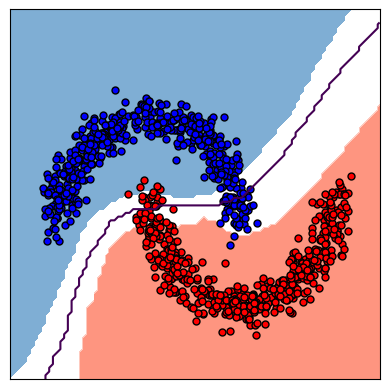

In [95]:
from matplotlib.colors import ListedColormap
N=8
M=20
s=2
dpa_prop = 1.0
### Visualise the results (AGT)
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

ensemble_preds = torch.load(f".prop_results/ensemble_preds_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
agt_uncert = torch.tensor(torch.load(f".prop_results/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")['z']).to(device)
preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])
cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
print((cert_preds == 0).sum())
pastel_red = "#FE2C02"   # Soft pinkish-red
pastel_blue = "#015FAA"  # Light pastel blue
cmap = ListedColormap([pastel_red, "white", pastel_blue])
ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

# save fig
plt.savefig(f"../figures/prop_{dpa_prop}_agt_moons_{N}_{M}_{s}.pdf", dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib.colors import ListedColormap
# Plot  
N=5
M=20
s=2
### Visualise the results (AGT)
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

ensemble_preds = torch.load(f".results/ensemble_preds_agt_dpa_{N}_{M}_{s}.pth")
agt_uncert = torch.tensor(torch.load(f".results/moons_agt_p_k={N}_{M}_{s}.pth")['z']).to(device)
preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])
cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
print((cert_preds == 0).sum())
pastel_red = "#FE2C02"   # Soft pinkish-red
pastel_blue = "#015FAA"  # Light pastel blue
cmap = ListedColormap([pastel_red, "white", pastel_blue])
ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

# save fig
# plt.savefig(f"../figures/agt_moons_{N}_{M}_{s}.pdf", dpi=300, bbox_inches='tight')

In [91]:
from matplotlib.colors import ListedColormap

def plot_subplot(ax, N, M, s, dpa_prop):
    ensemble_preds = torch.load(f".prop_results/ensemble_preds_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
    agt_uncert = torch.tensor(torch.load(f".prop_results/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")['z']).to(device)
    preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
    ax.contour(X0, X1, preds, levels=[0.5])
    cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
    cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
    cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
    print((cert_preds == 0).sum())
    pastel_red = "#FE2C02"   # Soft pinkish-red
    pastel_blue = "#015FAA"  # Light pastel blue
    cmap = ListedColormap([pastel_red, "white", pastel_blue])
    ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)
    
    # plot the moons
    ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
    ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

487
1163
1602
1933
1868


/tmp/ipykernel_3660838/418186251.py:46: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


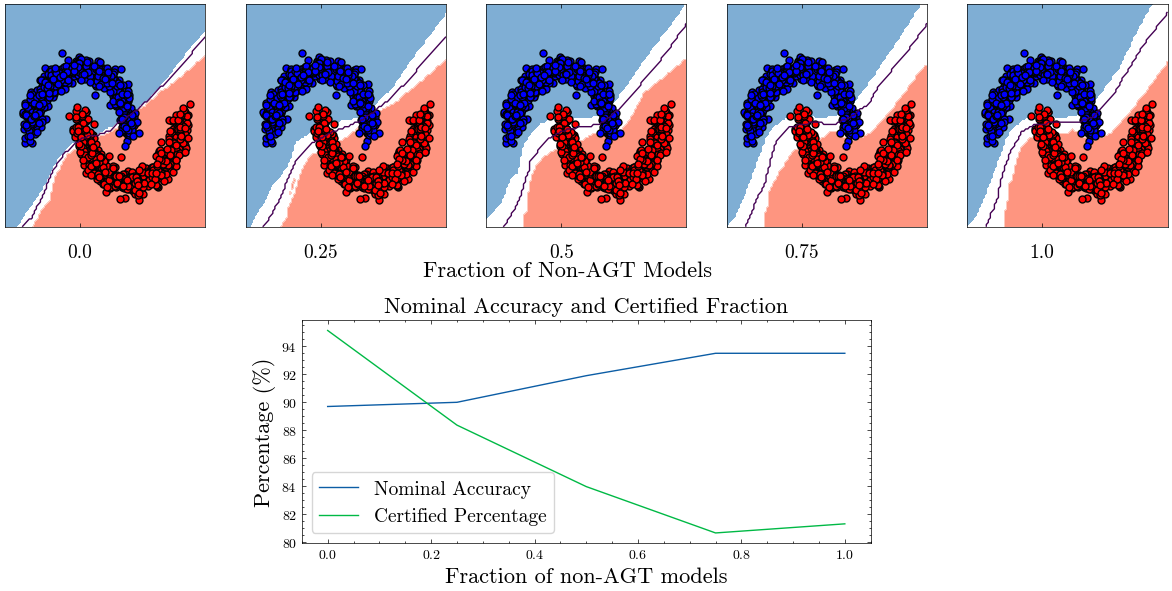

In [ ]:
import matplotlib.gridspec as gridspec
plt.style.use(["science", "no-latex"])
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1.2])
gs1 = gridspec.GridSpec(2, 8, height_ratios=[1.2, 1])

# Top row: 3 subplots across all columns
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])

# Bottom row: center 2 plots in columns 1 and 2
ax6 = fig.add_subplot(gs1[1, 2:6])  # spans columns 0 and 1

dpa_props = [0.0, 0.25, 0.5, 0.75, 1.0]
N = 8
M = 20
s = 2
nom_accs = [89.70, 90, 91.90, 93.5, 93.5]
cs = [95.13, 88.37, 83.98, 80.67, 81.32]
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    plot_subplot(ax, N, M, s, dpa_props[i])
    ax.set_xticks([0])
    ax.set_xticklabels([dpa_props[i]], fontdict={'fontsize': 14})
    for label in ax.get_xticklabels():
        label.set_y(label.get_position()[1] - 0.05)

    # Remove y-axis and spines
    ax.set_yticks([])

# plot line grpah of nom_accs
ax6.plot(dpa_props, nom_accs, label='Nominal Accuracy')
ax6.plot(dpa_props, cs, label='Certified Percentage')
ax6.legend(
    fontsize=14,  # Legend font size
    frameon=True,              # Show legend box
)
ax6.set_xlabel('Fraction of non-AGT models', fontsize=16)
ax6.set_ylabel('Percentage (%)', fontsize=16)
ax6.set_title('Nominal Accuracy and Certified Fraction', fontsize=16)

plt.figtext(0.5, 0.51, 'Fraction of Non-AGT Models', ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.savefig(f"../figures/prop_agt_moons_{N}_{M}_{s}_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

487
1163
1602
1933
1868


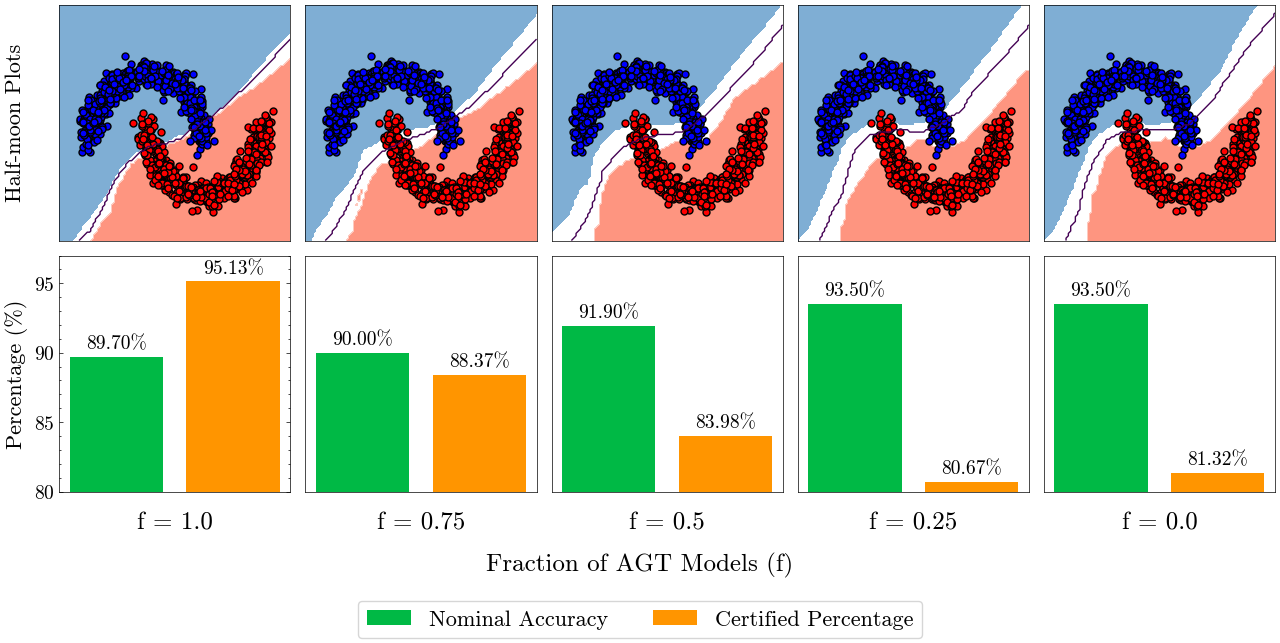

In [97]:
device = "cpu"
import matplotlib.gridspec as gridspec
plt.style.use(["science", "no-latex"])
fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1])

# Top row: 3 subplots across all columns
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])


dpa_props = [0.0, 0.25, 0.5, 0.75, 1.0]
N = 8
M = 20
s = 2
nom_accs = [89.70, 90, 91.90, 93.5, 93.5]
cs = [95.13, 88.37, 83.98, 80.67, 81.32]
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    plot_subplot(ax, N, M, s, dpa_props[i])
    # Remove y-axis and spines
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel('Half-moon Plots', fontsize=16, labelpad=25)
        ax.tick_params(axis='y', labelsize=14)

xs = ["Nominal Accuracy", "Certified Percentage"]
for i in range(5):
    ax = fig.add_subplot(gs[1, i])
    # plot bar plot with nom_accs and cs
    bar_nom = ax.bar(xs[0], nom_accs[i], color='C1', width=0.8, label='Nominal Accuracy')
    bar_cert = ax.bar(xs[1], cs[i], color='C2', width=0.8, label='Certified Percentage')
    
     # Add labels on bars
    ax.bar_label(bar_nom, labels=[f"{nom_accs[i]:.2f}%"], label_type='edge', padding=3, fontsize=14)
    ax.bar_label(bar_cert, labels=[f"{cs[i]:.2f}%"], label_type='edge', padding=3, fontsize=14)
    if i == 0:
        ax.set_ylabel('Percentage (%)', fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(80, 97)
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    ax.set_xlabel(f"f = {1-dpa_props[i]}", fontdict={'fontsize': 18}, labelpad=15)
    
handles, labels = fig.axes[5].get_legend_handles_labels()
fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        ncol=5,
        frameon=True,
        fontsize=16,  # Legend font size
    )

# plt.figtext(0.5, 0.51, 'Fraction of Non-AGT Models', ha='center', va='center', fontsize=16)
fig.supxlabel('Fraction of AGT Models (f)', fontsize=18, y=0.02)

plt.tight_layout()
plt.savefig(f"../figures/prop_agt_moons_{N}_{M}_{s}_comparison_1.pdf", dpi=300, bbox_inches='tight')
plt.show()